### Libraries

In [1]:
import sys
import os
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import numpy as np
import pandas as pd
import plotly_express as px
from datetime import datetime 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import LSTM, TimeDistributed, Input
from tensorflow.keras.models import load_model

### MLFlow settings

Setup MLflow:

In [2]:
import mlflow

# Get absolute path for MLflow directory
mlflow_dir = os.path.abspath("../data/mlflow")

# Create fresh directory
os.makedirs(mlflow_dir, exist_ok=True)

# Basic MLflow config - use file protocol with absolute path 
mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

# Set up FuelProphet experiment
try:
    experiment_name = "FuelProphet_CCN_Testing-CCN-LSTM-1_Loop_1"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment is None:
        # Only create if it doesn't exist
        mlflow.create_experiment(experiment_name)
        
    # Set as active experiment
    mlflow.set_experiment(experiment_name)
    print("FuelProphet experiment setup successful!")
    
except Exception as e:
    print(f"MLflow error: {e}")

mlflow.keras.autolog(log_models=False)

Traceback (most recent call last):
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 347, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 445, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1588, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/trac

FuelProphet experiment setup successful!


### My own functions

In [ ]:
from functions_laura.Data_processing import resample_one_station

# Deep Neural Networks for Time Series Analysis

We can use Deep Neural Networks to analyze time series. There are several options how to do this. 
We can use 
* convolutional neural networks (CNN)
* long-term short memory (LSTM)

or even hybrid models that combine CNN and LSTM layers.

Additionally to the timeseries data that we put in to analyze, we can add features to improve model performance.

### potential features
In the case of gas stations, we can think of the following features that potentially have an effect:
* Day of the week
* Station Type (LKW, Automat, Autobahn, rest stop)
* Oil price
* Exchange Rate
* Location
* Density
* Brand
* Dominant Gas station
* Opening times
* Mean price in radius or city

First, we load the data and clean it a little bit:

# Loading train/test data

In [4]:
# Train
df01_train = pd.read_parquet('../data/parquet_4_testing_2/train_01.parquet')
df02_train = pd.read_parquet('../data/parquet_4_testing_2/train_02.parquet')
df03_train = pd.read_parquet('../data/parquet_4_testing_2/train_03.parquet')
df04_train = pd.read_parquet('../data/parquet_4_testing_2/train_04.parquet')
df05_train = pd.read_parquet('../data/parquet_4_testing_2/train_05.parquet')
df06_train = pd.read_parquet('../data/parquet_4_testing_2/train_06.parquet')
df07_train = pd.read_parquet('../data/parquet_4_testing_2/train_07.parquet')
df08_train = pd.read_parquet('../data/parquet_4_testing_2/train_08.parquet')
df09_train = pd.read_parquet('../data/parquet_4_testing_2/train_09.parquet')
df10_train = pd.read_parquet('../data/parquet_4_testing_2/train_10.parquet')
df11_train = pd.read_parquet('../data/parquet_4_testing_2/train_11.parquet')
df12_train = pd.read_parquet('../data/parquet_4_testing_2/train_12.parquet')
df13_train = pd.read_parquet('../data/parquet_4_testing_2/train_13.parquet')
df14_train = pd.read_parquet('../data/parquet_4_testing_2/train_14.parquet')
df15_train = pd.read_parquet('../data/parquet_4_testing_2/train_15.parquet')
df16_train = pd.read_parquet('../data/parquet_4_testing_2/train_16.parquet')
df17_train = pd.read_parquet('../data/parquet_4_testing_2/train_17.parquet')
df18_train = pd.read_parquet('../data/parquet_4_testing_2/train_18.parquet')
df19_train = pd.read_parquet('../data/parquet_4_testing_2/train_19.parquet')
df20_train = pd.read_parquet('../data/parquet_4_testing_2/train_20.parquet')
df21_train = pd.read_parquet('../data/parquet_4_testing_2/train_21.parquet')
df22_train = pd.read_parquet('../data/parquet_4_testing_2/train_22.parquet')
df23_train = pd.read_parquet('../data/parquet_4_testing_2/train_23.parquet')
df24_train = pd.read_parquet('../data/parquet_4_testing_2/train_24.parquet')
df25_train = pd.read_parquet('../data/parquet_4_testing_2/train_25.parquet')
df26_train = pd.read_parquet('../data/parquet_4_testing_2/train_26.parquet')
df27_train = pd.read_parquet('../data/parquet_4_testing_2/train_27.parquet')
df28_train = pd.read_parquet('../data/parquet_4_testing_2/train_28.parquet')
df29_train = pd.read_parquet('../data/parquet_4_testing_2/train_29.parquet')
df30_train = pd.read_parquet('../data/parquet_4_testing_2/train_30.parquet')

# Test
df01_test = pd.read_parquet('../data/parquet_4_testing_2/test_01.parquet')
df02_test = pd.read_parquet('../data/parquet_4_testing_2/test_02.parquet')
df03_test = pd.read_parquet('../data/parquet_4_testing_2/test_03.parquet')
df04_test = pd.read_parquet('../data/parquet_4_testing_2/test_04.parquet')
df05_test = pd.read_parquet('../data/parquet_4_testing_2/test_05.parquet')
df06_test = pd.read_parquet('../data/parquet_4_testing_2/test_06.parquet')
df07_test = pd.read_parquet('../data/parquet_4_testing_2/test_07.parquet')
df08_test = pd.read_parquet('../data/parquet_4_testing_2/test_08.parquet')
df09_test = pd.read_parquet('../data/parquet_4_testing_2/test_09.parquet')
df10_test = pd.read_parquet('../data/parquet_4_testing_2/test_10.parquet')
df11_test = pd.read_parquet('../data/parquet_4_testing_2/test_11.parquet')
df12_test = pd.read_parquet('../data/parquet_4_testing_2/test_12.parquet')
df13_test = pd.read_parquet('../data/parquet_4_testing_2/test_13.parquet')
df14_test = pd.read_parquet('../data/parquet_4_testing_2/test_14.parquet')
df15_test = pd.read_parquet('../data/parquet_4_testing_2/test_15.parquet')
df16_test = pd.read_parquet('../data/parquet_4_testing_2/test_16.parquet')
df17_test = pd.read_parquet('../data/parquet_4_testing_2/test_17.parquet')
df18_test = pd.read_parquet('../data/parquet_4_testing_2/test_18.parquet')
df19_test = pd.read_parquet('../data/parquet_4_testing_2/test_19.parquet')
df20_test = pd.read_parquet('../data/parquet_4_testing_2/test_20.parquet')
df21_test = pd.read_parquet('../data/parquet_4_testing_2/test_21.parquet')
df22_test = pd.read_parquet('../data/parquet_4_testing_2/test_22.parquet')
df23_test = pd.read_parquet('../data/parquet_4_testing_2/test_23.parquet')
df24_test = pd.read_parquet('../data/parquet_4_testing_2/test_24.parquet')
df25_test = pd.read_parquet('../data/parquet_4_testing_2/test_25.parquet')
df26_test = pd.read_parquet('../data/parquet_4_testing_2/test_26.parquet')
df27_test = pd.read_parquet('../data/parquet_4_testing_2/test_27.parquet')
df28_test = pd.read_parquet('../data/parquet_4_testing_2/test_28.parquet')
df29_test = pd.read_parquet('../data/parquet_4_testing_2/test_29.parquet')
df30_test = pd.read_parquet('../data/parquet_4_testing_2/test_30.parquet')

# Rename date to datetime

In [6]:
# Train
df01_train.rename(columns={"date": "datetime"}, inplace=True)
df02_train.rename(columns={"date": "datetime"}, inplace=True)
df03_train.rename(columns={"date": "datetime"}, inplace=True)
df04_train.rename(columns={"date": "datetime"}, inplace=True)
df05_train.rename(columns={"date": "datetime"}, inplace=True)
df06_train.rename(columns={"date": "datetime"}, inplace=True)
df07_train.rename(columns={"date": "datetime"}, inplace=True)
df08_train.rename(columns={"date": "datetime"}, inplace=True)
df09_train.rename(columns={"date": "datetime"}, inplace=True)
df10_train.rename(columns={"date": "datetime"}, inplace=True)
df11_train.rename(columns={"date": "datetime"}, inplace=True)
df12_train.rename(columns={"date": "datetime"}, inplace=True)
df13_train.rename(columns={"date": "datetime"}, inplace=True)
df14_train.rename(columns={"date": "datetime"}, inplace=True)
df15_train.rename(columns={"date": "datetime"}, inplace=True)
df16_train.rename(columns={"date": "datetime"}, inplace=True)
df17_train.rename(columns={"date": "datetime"}, inplace=True)
df18_train.rename(columns={"date": "datetime"}, inplace=True)
df19_train.rename(columns={"date": "datetime"}, inplace=True)
df20_train.rename(columns={"date": "datetime"}, inplace=True)
df21_train.rename(columns={"date": "datetime"}, inplace=True)
df22_train.rename(columns={"date": "datetime"}, inplace=True)
df23_train.rename(columns={"date": "datetime"}, inplace=True)
df24_train.rename(columns={"date": "datetime"}, inplace=True)
df25_train.rename(columns={"date": "datetime"}, inplace=True)
df26_train.rename(columns={"date": "datetime"}, inplace=True)
df27_train.rename(columns={"date": "datetime"}, inplace=True)
df28_train.rename(columns={"date": "datetime"}, inplace=True)
df29_train.rename(columns={"date": "datetime"}, inplace=True)
df30_train.rename(columns={"date": "datetime"}, inplace=True)


# Test
df01_test.rename(columns={"date": "datetime"}, inplace=True)
df02_test.rename(columns={"date": "datetime"}, inplace=True) 
df03_test.rename(columns={"date": "datetime"}, inplace=True) 
df04_test.rename(columns={"date": "datetime"}, inplace=True) 
df05_test.rename(columns={"date": "datetime"}, inplace=True) 
df06_test.rename(columns={"date": "datetime"}, inplace=True) 
df07_test.rename(columns={"date": "datetime"}, inplace=True) 
df08_test.rename(columns={"date": "datetime"}, inplace=True) 
df09_test.rename(columns={"date": "datetime"}, inplace=True) 
df10_test.rename(columns={"date": "datetime"}, inplace=True) 
df11_test.rename(columns={"date": "datetime"}, inplace=True) 
df12_test.rename(columns={"date": "datetime"}, inplace=True) 
df13_test.rename(columns={"date": "datetime"}, inplace=True) 
df14_test.rename(columns={"date": "datetime"}, inplace=True) 
df15_test.rename(columns={"date": "datetime"}, inplace=True) 
df16_test.rename(columns={"date": "datetime"}, inplace=True) 
df17_test.rename(columns={"date": "datetime"}, inplace=True) 
df18_test.rename(columns={"date": "datetime"}, inplace=True) 
df19_test.rename(columns={"date": "datetime"}, inplace=True) 
df20_test.rename(columns={"date": "datetime"}, inplace=True) 
df21_test.rename(columns={"date": "datetime"}, inplace=True) 
df22_test.rename(columns={"date": "datetime"}, inplace=True) 
df23_test.rename(columns={"date": "datetime"}, inplace=True) 
df24_test.rename(columns={"date": "datetime"}, inplace=True) 
df25_test.rename(columns={"date": "datetime"}, inplace=True) 
df26_test.rename(columns={"date": "datetime"}, inplace=True) 
df27_test.rename(columns={"date": "datetime"}, inplace=True) 
df28_test.rename(columns={"date": "datetime"}, inplace=True) 
df29_test.rename(columns={"date": "datetime"}, inplace=True) 
df30_test.rename(columns={"date": "datetime"}, inplace=True) 

### Data processing (without feature engineering)

We split the data into train, test and validation:

[-------- Train --------][--- Validation ---][--- Test ---]


It is important to process the data correctly.


1) choose the data of one gas station (using the uuid)
2) define the training data and the test data to avoid data leakage
3) define your sliding window 
4) Create sequences of your train data
5) Create sequences of your test data defining input and output 


### The sliding window to prepare sequential data
so it can fit into my model. We are using a sliding window of 288 (1 day). After every 288 e5 prices, we look at the price that comes after it. 
$X$ is an array consisting of all the sequences, so it has 288 columns.
$y$ is a 1D array of all these values that come after the 288 (= the next step)

$X$ and $y$ have 288 less rows than the original df, because:

| i    | Input `X[i]` (rows used) | Target `y[i]` |
| ---- | ------------------------ | ------------- |
| 0    | rows 0 to 287            | row 288, E5   |
| 1    | rows 1 to 288            | row 289, E5   |
| 2    | rows 2 to 289            | row 290, E5   |
| ...  | ...                      | ...           |
| 9711 | rows 9711 to 9998        | row 9999, E5  |

# Function Script:

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
import mlflow.keras
import keras
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Input


###################################################################################################
def prepare_forecast_data(df_test, scaler,
                            forecast_output_start,
                            days_output,
                            fuel='e5',
                            window_size=288):
    """
    Prepare scaled forecast input data for multi-step forecasting using one column (e.g., 'e5').

    Parameters:
    - df: pandas DataFrame with datetime index
    - scaler: fitted MinMaxScaler
    - forecast_input_start: datetime, start of input window
    - forecast_output_start: datetime, start of output window
    - days_input: number of days for input
    - days_output: number of days for prediction
    - fuel: string, name of the column to use (default: 'e5')
    - window_size: number of steps per day (default: 288 for 5-min data)

    Returns:
    - X_forecast: np.array of shape (steps_to_predict, window_size, 1)
    ###- forecast_timestamps: list of timestamps corresponding to each prediction###
    """
    df = df_test.copy()
    
    
    df["time_index"] = np.arange(len(df))

    input_mask = (df.index < forecast_output_start)
    output_mask = (df.index >= forecast_output_start) & (
        df.index < forecast_output_start + pd.Timedelta(days=days_output)
    )

    input_rows = df[input_mask]["time_index"].values
    output_rows = df[output_mask]["time_index"].values

    # expected_input_rows = days_input * window_size
    # expected_output_rows = days_output * window_size

    # if len(input_rows) != expected_input_rows:
    #     raise ValueError(f"Expected {expected_input_rows} input rows, got {len(input_rows)}")
    # if len(output_rows) != expected_output_rows:
    #     raise ValueError(f"Expected {expected_output_rows} output rows, got {len(output_rows)}")

    start_idx = input_rows[0]
    end_idx = output_rows[-1] + 1

    values = df[[fuel]].values
    scaled_values = scaler.transform(values)
    forecast_slice = scaled_values[start_idx:end_idx]

    total_target_steps = len(output_rows)
    X_forecast = []

    for i in range(total_target_steps):
        window = forecast_slice[i:i + window_size]
        X_forecast.append(window)

    X_forecast = np.array(X_forecast)  # shape: (288, 288, 1)
    #forecast_timestamps = df.iloc[output_rows].index.tolist()

    y_test = df.loc[
    (df.index >= forecast_output_start) &
    (df.index < forecast_output_start + pd.Timedelta(days=days_output)),
    fuel  # or whatever fuel column you're forecasting
    ].values.reshape(-1, 1)

    return X_forecast, y_test
####################################################################################################
def create_sequences(
        data, 
        window_size, 
        target_col_index):
    """Create sequences for time series prediction.
    
    Args:
        data: Scaled input data with shape (samples, features)
        window_size: Number of time steps to look back
        target_col_index: Index of the target column to predict
        
    Returns:
        X: Input sequences with shape (samples, window_size, features)
        y: Target values with shape (samples,)
    """
    X = []
    y = []
    for i in range(len(data) - window_size):
        # Get sequence of all features
        sequence = data[i:(i + window_size)]
        X.append(sequence)
        # Get next value of target feature
        target = data[i + window_size, target_col_index]
        y.append(target)
    return np.array(X), np.array(y)
##################################################################
def preprocess(
        df_train, df_test,
        start_forecast=None,
        fuel='e5',
        output_days=1,
        verbose=True
        ):
    
    # Filter and resample
    df_train = resample_one_station(df_train)
    df_test = resample_one_station(df_test)

    # Split data
    # Find the middle point of df_test
    middle_idx = len(df_train) // 2
    
    test_df = df_test
    train_df = df_train[:middle_idx].copy()  # First half
    val_df = df_train[middle_idx:].copy()  # Second half

    # set datetime index
    train_df.set_index('datetime', inplace=True)
    val_df.set_index('datetime', inplace=True)
    test_df.set_index('datetime', inplace=True)

    # Calculate start_forecast automatically (output_days days before end of test set)
    start_forecast = test_df.index.max() - pd.Timedelta(days=output_days)

    # Scaling
    scaler = MinMaxScaler()
    scaler.fit(train_df[[fuel]])

    scaled_train = scaler.transform(train_df[[fuel]])
    scaled_val = scaler.transform(val_df[[fuel]])
    #scaled_test = scaler.transform(test_df[[fuel]])  # optional

    # Sequence generation
    window_size = 288
    target_col_index = 0

    X, y = create_sequences(scaled_train, window_size, target_col_index)
    X_val, y_val = create_sequences(scaled_val, window_size, target_col_index)

    # Forecast setup
    start_forecast = pd.to_datetime(start_forecast)
    X_forecast, y_test = prepare_forecast_data(test_df, forecast_output_start=start_forecast,
                                       days_output=output_days, scaler=scaler)


    ### === Verbose plots === ###
    if verbose:
        # Time series overview
        plt.figure(figsize=(10,6))
        plt.plot(train_df.index, train_df[fuel], label='Train', drawstyle='steps-post')
        plt.plot(val_df.index, val_df[fuel], label='Validation', drawstyle='steps-post')
        plt.plot(test_df.index, test_df[fuel], label='Test', drawstyle='steps-post')
        plt.title("Train, Validation, and Test Data")
        plt.xlabel("Date")
        plt.ylabel(f"{fuel} Price")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("Data_overview.png")
        mlflow.log_artifact("Data_overview.png")
        plt.show()

        # KDE for distribution comparison
        kde_train = gaussian_kde(train_df[fuel].dropna())
        kde_val = gaussian_kde(val_df[fuel].dropna())
        kde_test = gaussian_kde(test_df[fuel].dropna())

        x_vals = np.linspace(
            min(train_df[fuel].min(), val_df[fuel].min(), test_df[fuel].min()),
            max(train_df[fuel].max(), val_df[fuel].max(), test_df[fuel].max()), 1000
        )

        plt.figure(figsize=(10,4))
        plt.plot(x_vals, kde_train(x_vals), label='Train', color='blue')
        plt.plot(x_vals, kde_val(x_vals), label='Validation', color='green')
        plt.plot(x_vals, kde_test(x_vals), label='Test', color='orange')
        plt.title(f"KDE of {fuel} in Train, Validation, Test")
        plt.xlabel(f"{fuel} Value")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.savefig("KDE.png")
        mlflow.log_artifact("KDE.png")
        plt.show()

        # Log preprocessing parameters
        mlflow.log_params({
                "train_size": len(train_df),
                "val_size": len(val_df),
                "test_size": len(test_df),
                "window_size": window_size,
                "fuel_type": fuel,
                "output_days": output_days
            })

    return X, y, X_val, y_test, y_val, X_forecast, scaler, scaled_train, val_df, test_df
###########################
def build_model(model_type, params, input_shape=(288, 1)):
    model = Sequential()
    if model_type == 'cnn_small':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu')) # 1-dimensional deconvolution
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        ########################################################################
    elif model_type == 'cnn_big':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(100, activation='relu'))
        model.add(Dropout(0.2))
        ########################################################################
    elif model_type == 'cnn_lstm_1':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(params['lstm_units'], return_sequences=False))
        ########################################################################
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    model.add(Dense(1))  # Output layer

    model.compile(optimizer='adam', loss='mse')

    return model

###########################

def train_model_with_mlflow(X, y, X_val, y_val, model_type, params, days_output=None, input_shape=(288, 1)):
        # Log parameters manually (optional if autolog is on)
        mlflow.log_param("days_output", days_output)
        mlflow.set_tag("dataset", f'{dataset_name}')
        mlflow.set_tag("model_type", model_type)

        
        model = build_model(model_type=model_type, params=params, input_shape=input_shape)
        # Train model
        history = model.fit(
            X, y,
            validation_data=(X_val, y_val),
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=1
        )

        # Log final metrics manually if you want more control
        final_val_loss = history.history['val_loss'][-1]
        mlflow.log_metric("final_val_loss", final_val_loss)

        # Optionally log a plot
        plt.figure()
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='val')
        plt.title("Loss over Epochs")
        plt.legend()
        plt.savefig("loss_plot.png")
        mlflow.log_artifact("loss_plot.png")

        model_path = 'model.keras'
        keras.saving.save_model(model, model_path, save_format="keras")
        mlflow.log_artifact(model_path)

        return model, history
###########################

def inverse_scale(preds, original_data, target_index, scaler):
    """Inverse scale predictions by placing them into a dummy array 
    and applying scaler.inverse_transform."""
    dummy = np.zeros((len(preds), original_data.shape[1]))
    dummy[:, target_index] = preds.flatten()
    return scaler.inverse_transform(dummy)[:, target_index]

# Function that forecasts and prints the forecast
def forecasting(
        X_forecast,
        scaled_train,
        scaler,
        fuel='e5',
        model= None,
    ):
    '''
    _summary_

    Args:
        X_forecast (np.array): Output from processing function
        scaled_train (np.array): Output from processing function
        scaler (fitted MinMax Scaler): Output from processing function
        start_forecast (string): date of forecast start already defied in the processing function
        fuel (str, optional): Fuel type, 'es', 'e10' or 'diesel'. Defaults to 'e5'.
    '''

    #make predictions
    y_pred_forecast = model.predict(X_forecast)
    #scale the predictions back to original scale
    y_pred = inverse_scale(y_pred_forecast, scaled_train, target_index=0, scaler=scaler)
    
    # reattach the datetime to prediction
    n_predictions = len(y_pred)
    last_timestamp = test_df.index.max()
    start_datetime = last_timestamp - pd.Timedelta(days=output_days)
    time_index = pd.date_range(start=start_datetime, periods=n_predictions, freq="5min")

    #combine into a DataFrame
    y_pred_df = pd.DataFrame({
        "datetime": time_index,
        "Predicted E5": y_pred
    })
    #make datetime index
    y_pred_df.set_index('datetime', inplace=True)

    # Save forecast to file
    np.savetxt("forecast.csv", y_pred_df, delimiter=",") 
    mlflow.log_artifact("forecast.csv")

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    mlflow.log_metric("test_mae", mae)
    mlflow.log_metric("test_mape", mape)
    mlflow.log_metric("R2_score", r2)

    #print y_pred to check if it looks as expected
    print(y_pred_df.head()) 

    # Plot
    # Set parameters
    colors = {
        "background": "#f9fcfc",
        "gridcolor": "#dcdbd9",
        "legendedge": "#dcdbd9",
        "legendface": "white",
        "legendcol": "black",
        "textcolor": "black"
    }
    # Create a figure and axis with custom size
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(test_df[fuel], label=f'True Test {fuel}', drawstyle='steps-post', linewidth=3) # line width
    plt.plot(y_pred_df, drawstyle='steps-post', linewidth=3)
    # Set grid with custom color
    ax.grid(True, color=colors["gridcolor"])
    # Change border (spine) colors
    for spine in ax.spines.values():
        spine.set_edgecolor(colors["gridcolor"])
    # Set title and labels
    ax.set_title("Fuel price prediction of one gas station", fontweight="bold", fontsize=18, color=colors["textcolor"])
    ax.set_xlabel("time", fontweight="bold", fontsize=16, color=colors["textcolor"])
    ax.set_ylabel(f"{fuel} price (€/l)", fontweight="bold", fontsize=16, color=colors["textcolor"])
    # Customize tick labels
    for label in ax.get_xticklabels():
        label.set_fontsize(16)
        label.set_color(colors["textcolor"])
    for label in ax.get_yticklabels():
        label.set_fontsize(16)
        label.set_color(colors["textcolor"])
        label.set_fontweight('normal')
    # Set background color
    ax.set_facecolor(colors["background"])
    fig.patch.set_facecolor(colors["background"])
    # Create legend
    plt.legend(fontsize=16,loc='upper right', 
               edgecolor=params.get("legendedge"), 
               facecolor=params.get("legendface"), 
               labelcolor = params.get("legendcol"),
               framealpha=1)
    plt.savefig("forecast.png", facecolor=colors["background"])
    mlflow.log_artifact("forecast.png")
    plt.show()



# Start of the analysis

In [8]:
datasets = {
    'df01': (df01_train, df01_test),
    'df02': (df02_train, df02_test),
    'df03': (df03_train, df03_test),
    'df04': (df04_train, df04_test),
    'df05': (df05_train, df05_test),
    'df06': (df06_train, df06_test),
    'df07': (df07_train, df07_test),
    'df08': (df08_train, df08_test),
    'df09': (df09_train, df09_test),
    'df10': (df10_train, df10_test),
    'df11': (df11_train, df11_test),
    'df12': (df12_train, df12_test),
    'df13': (df13_train, df13_test),
    'df14': (df14_train, df14_test),
    'df15': (df15_train, df15_test),
    'df16': (df16_train, df16_test),
    'df17': (df17_train, df17_test),
    'df18': (df18_train, df18_test),
    'df19': (df19_train, df19_test),
    'df20': (df20_train, df20_test),
    'df21': (df21_train, df21_test),
    'df22': (df22_train, df22_test),
    'df23': (df23_train, df23_test),
    'df24': (df24_train, df24_test),
    'df25': (df25_train, df25_test),
    'df26': (df26_train, df26_test),
    'df27': (df27_train, df27_test),
    'df28': (df28_train, df28_test),
    'df29': (df29_train, df29_test),
    'df30': (df30_train, df30_test)
}

In [ ]:
# # LOOP
# for dataset_name, (df_train, df_test) in datasets.items():

#     mlflow.end_run()
#     # DATA

#     with mlflow.start_run(run_name=f"fuel_model_{dataset_name}") as run:
#         output_days = 1 # default
#         fuel='e5' # default

#         # PREPROCESSING
#         X, y, X_val, y_test, y_val, X_forecast, scaler, scaled_train, val_df, test_df = preprocess(
#                 df_train=df_train, 
#                 df_test=df_test, 
#         )

#         # MODELING
#         # 1. Set Params
#         params = {
#             'epochs': 30,
#             'batch_size': 32,
#             'lstm_units': 50
#         }

#         # 2. Set Model Type: 'cnn_small', 'cnn_big', 'cnn_lstm_1'
#         model_type = 'cnn_small'
#         #model_type = 'cnn_big'
#         #model_type = 'cnn_lstm_1'

#         trained_model, history = train_model_with_mlflow(
#                                                             X=X, 
#                                                             y=y, 
#                                                             X_val=X_val, 
#                                                             y_val=y_val,
#                                                             model_type=model_type,
#                                                             params=params
#                                                             )

#         # FORECASTING
#         forecasting(X_forecast = X_forecast, scaled_train = scaled_train, scaler = scaler, model=trained_model)

#     mlflow.end_run()


Processing dataset: df01


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


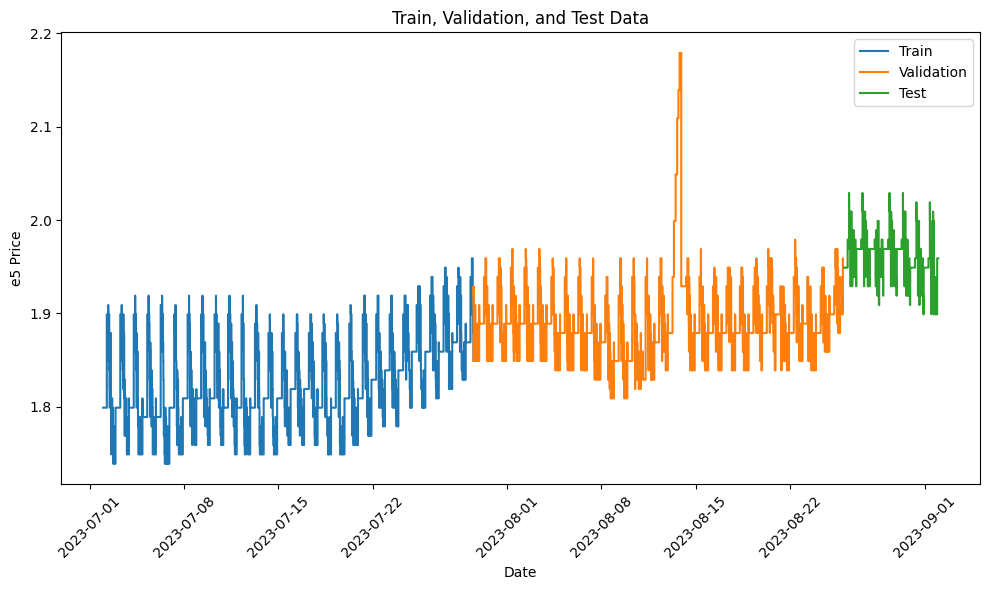

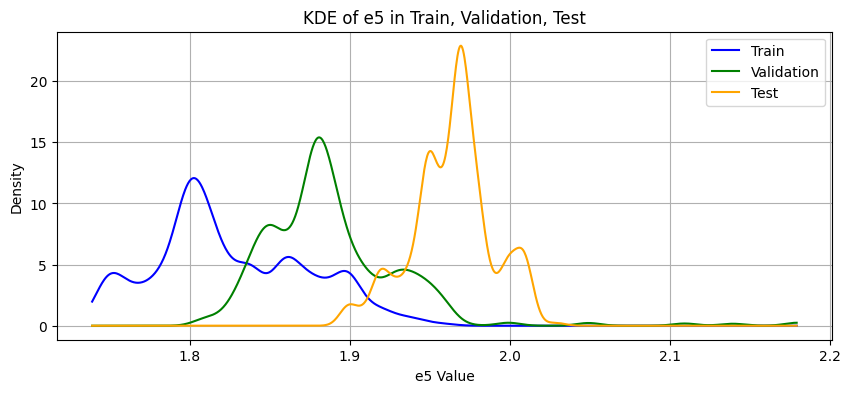

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0239 - val_loss: 0.0045
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
                     Predicted E5
datetime                         
2023-09-01 00:00:00      1.947015
2023-09-01 00:05:00      1.946614
2023-09-01 00:10:00      1.947805
2023-09-01 00:15:00      1.947812
2023-09-01 00:20:00      1.949227


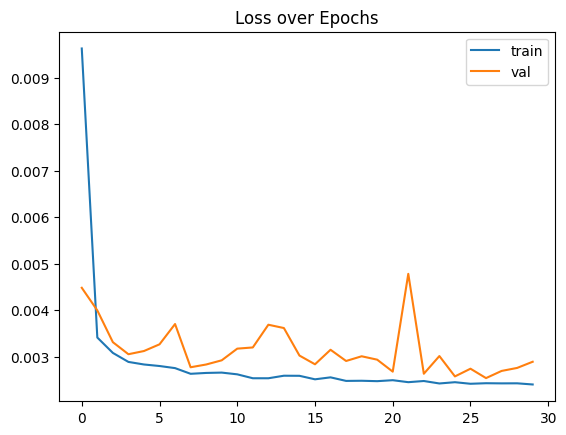

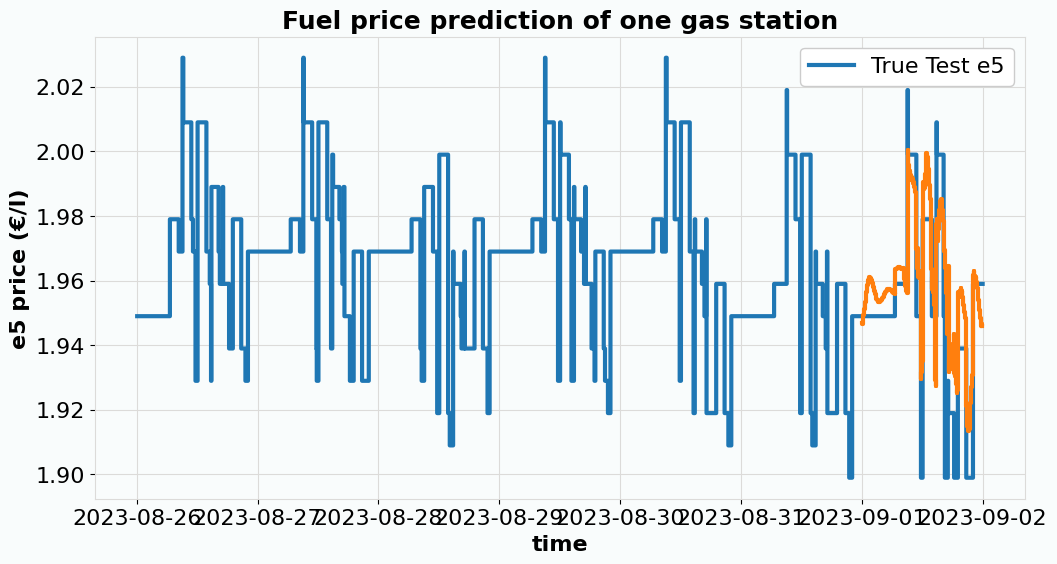

Successfully processed df01

Processing dataset: df02


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


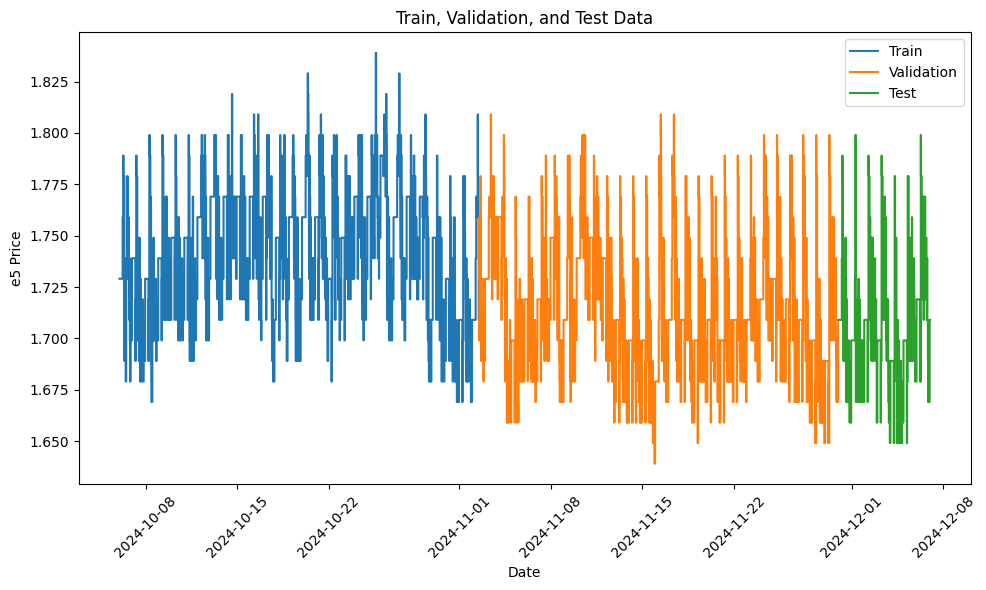

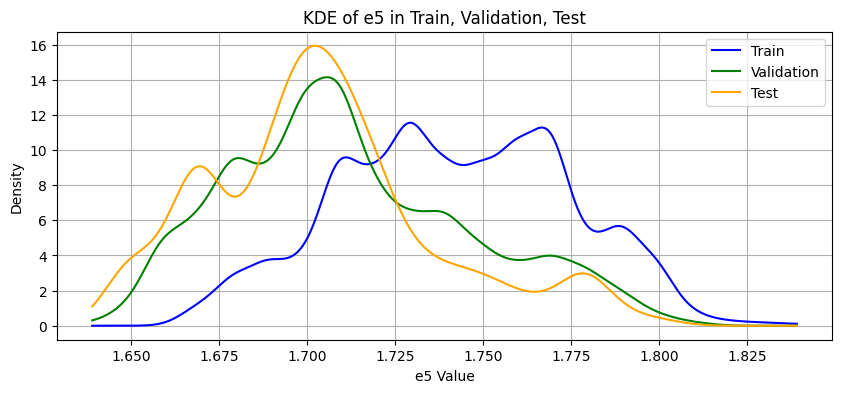

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0455 - val_loss: 0.0070
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0035 - val_loss: 0.0044
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2024-12-06 00:00:00      1.694413
2024-12-06 00:05:00      1.696342
2024-12-06 00:10:00      1.696249
2024-12-06 00:15:00      1.697540
2024-12-06 00:20:00      1.697531


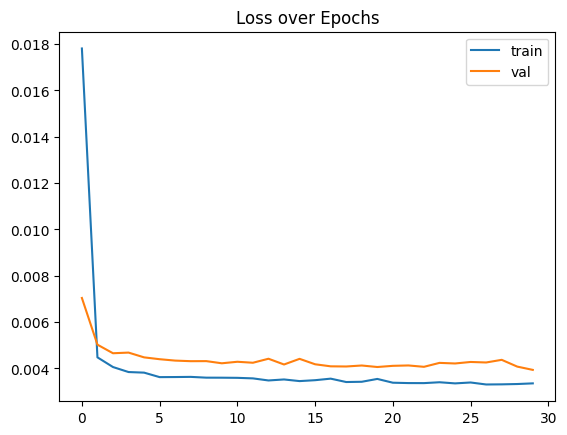

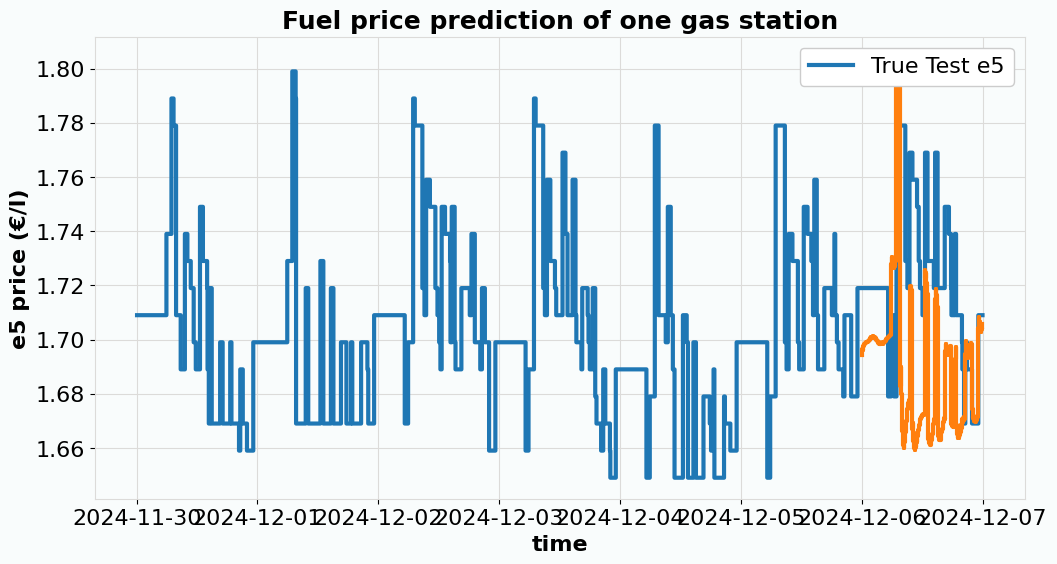

Successfully processed df02

Processing dataset: df03


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


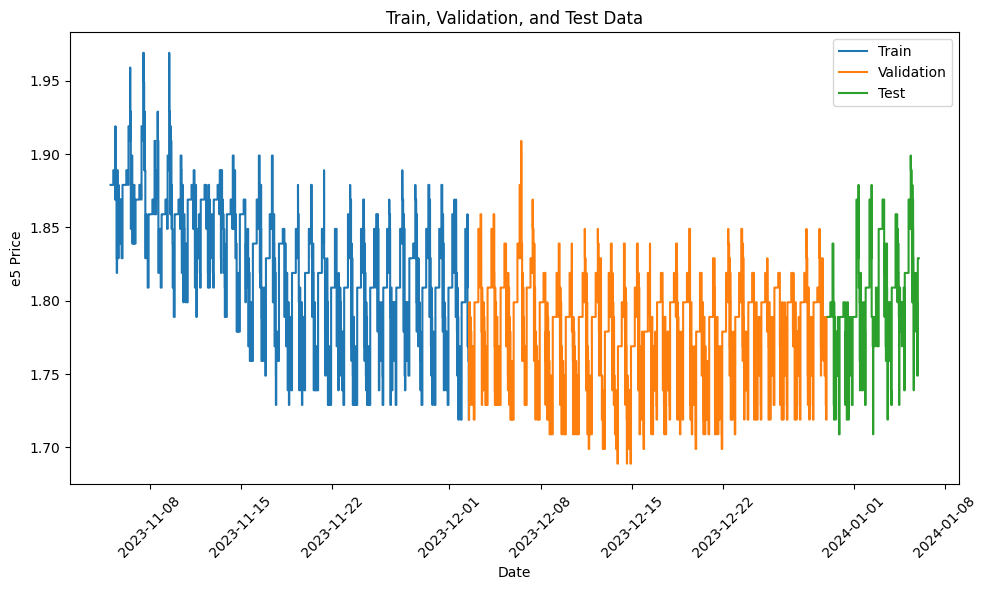

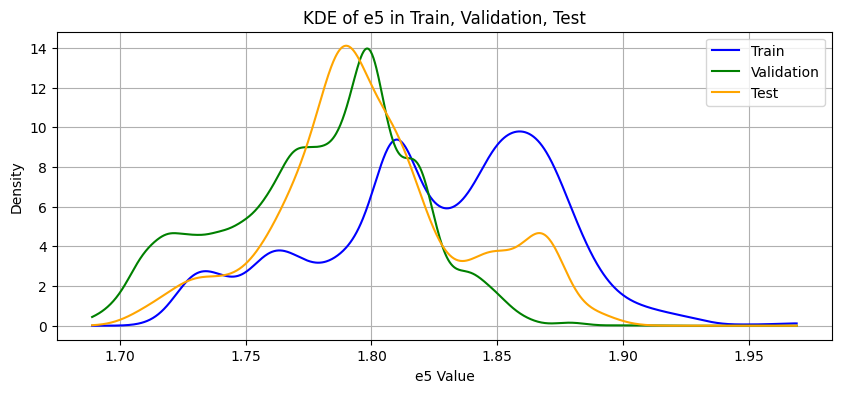

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0182 - val_loss: 0.0034
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
                     Predicted E5
datetime                         
2024-01-05 00:00:00      1.787070
2024-01-05 00:05:00      1.786641
2024-01-05 00:10:00      1.787532
2024-01-05 00:15:00      1.787165
2024-01-05 00:20:00      1.787951


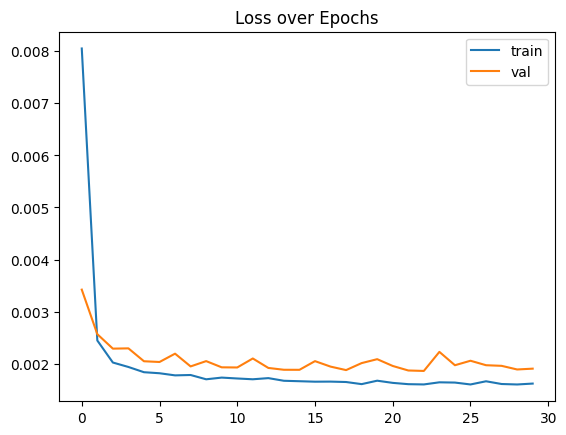

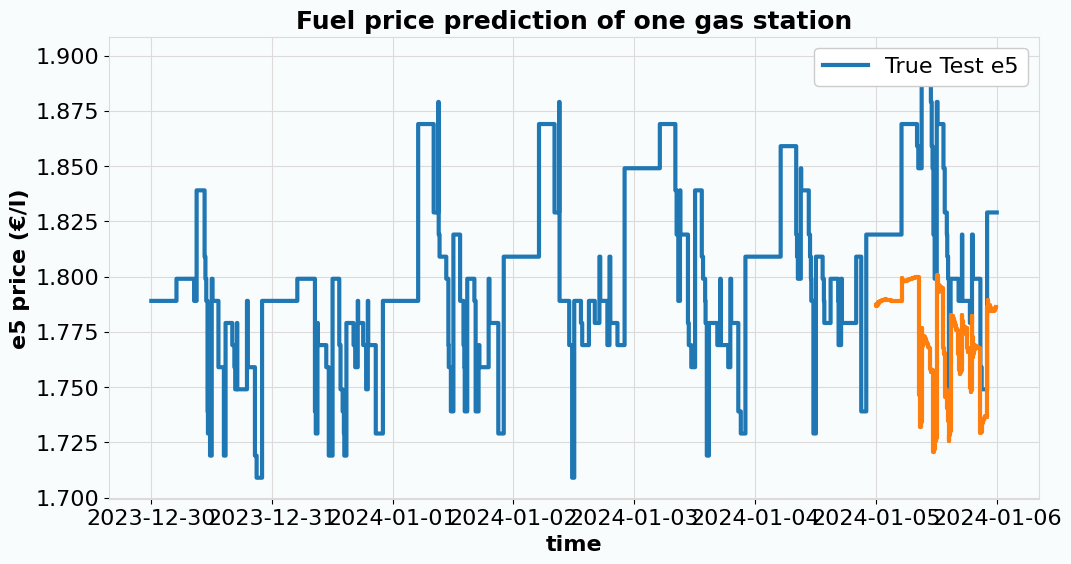

Successfully processed df03

Processing dataset: df04


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


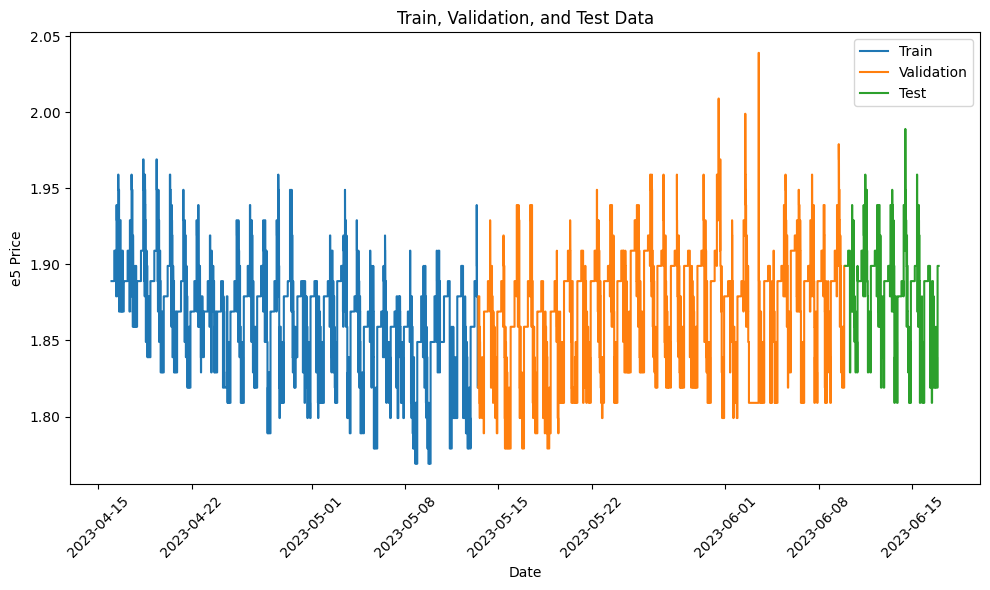

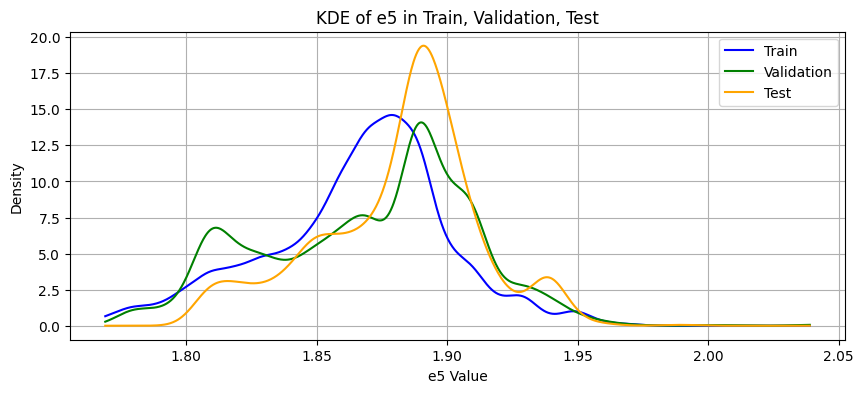

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0442 - val_loss: 0.0060
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2023-06-16 00:00:00      1.884075
2023-06-16 00:05:00      1.882743
2023-06-16 00:10:00      1.884307
2023-06-16 00:15:00      1.883040
2023-06-16 00:20:00      1.885050


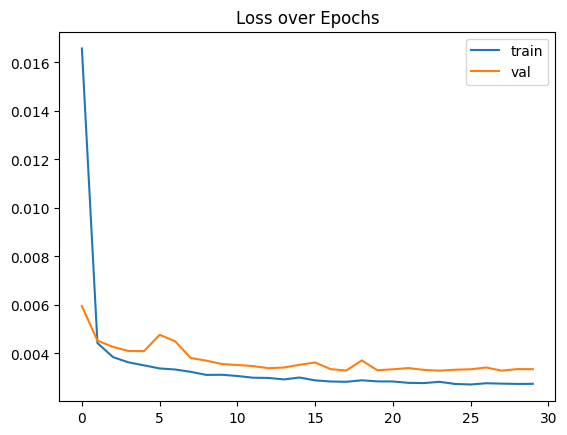

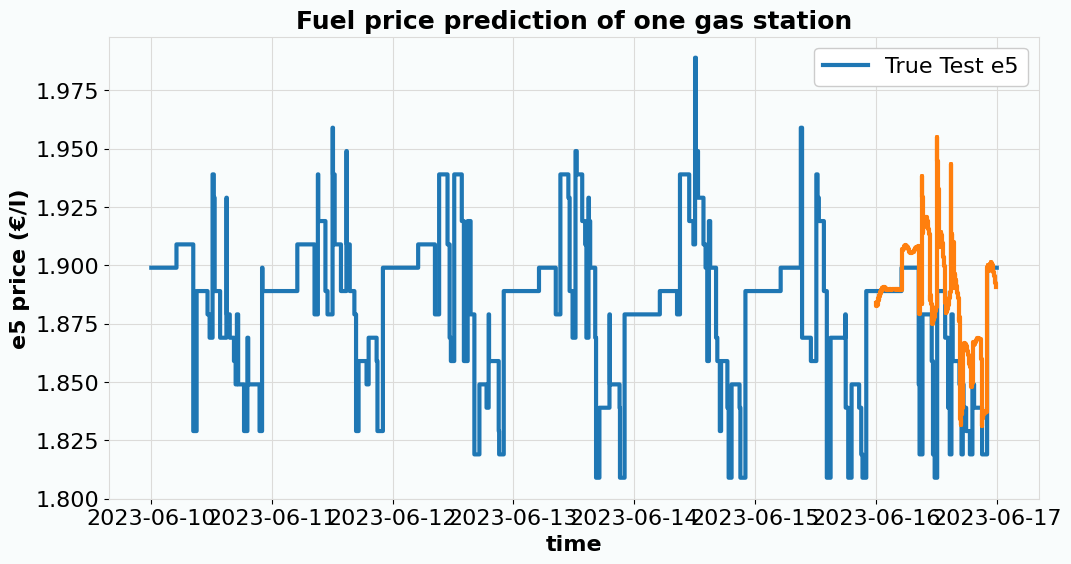

Successfully processed df04

Processing dataset: df05


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


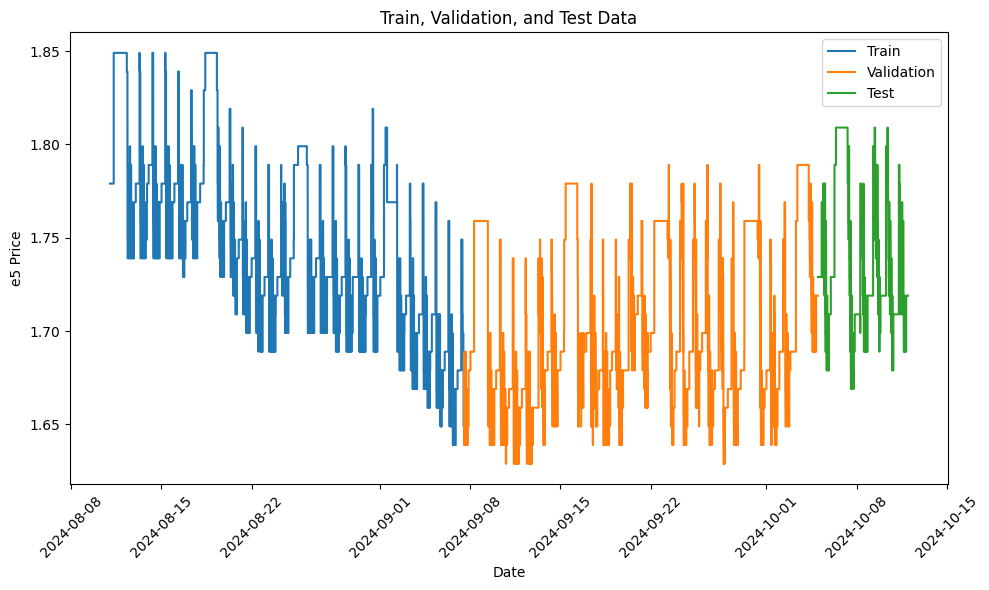

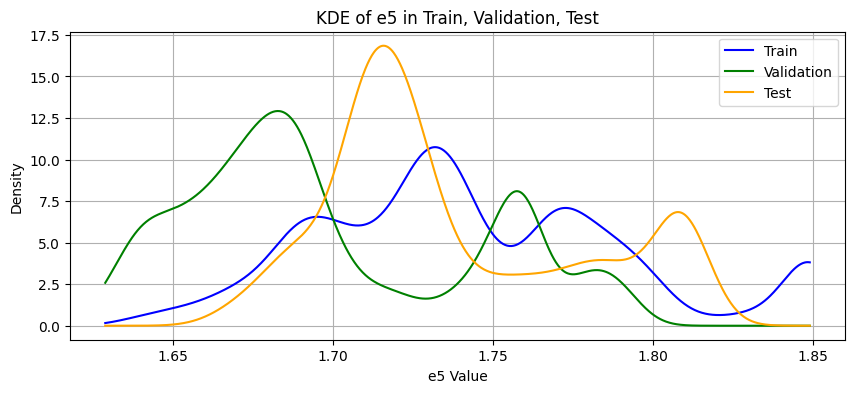

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0395 - val_loss: 0.0026
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 46s 191ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
                     Predicted E5
datetime                         
2024-10-11 00:00:00      1.709401
2024-10-11 00:05:00      1.726517
2024-10-11 00:10:00      1.726914
2024-10-11 00:15:00      1.726254
2024-10-11 00:20:00      1.726129


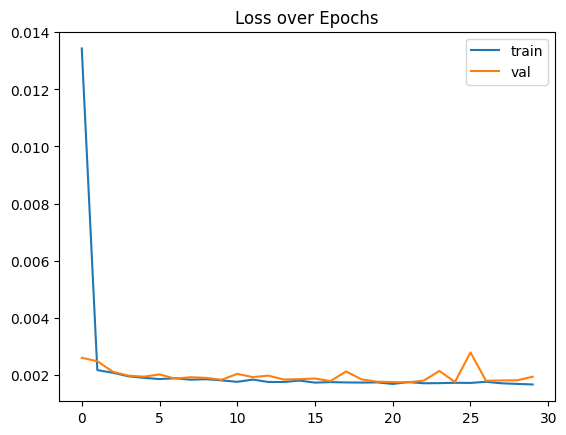

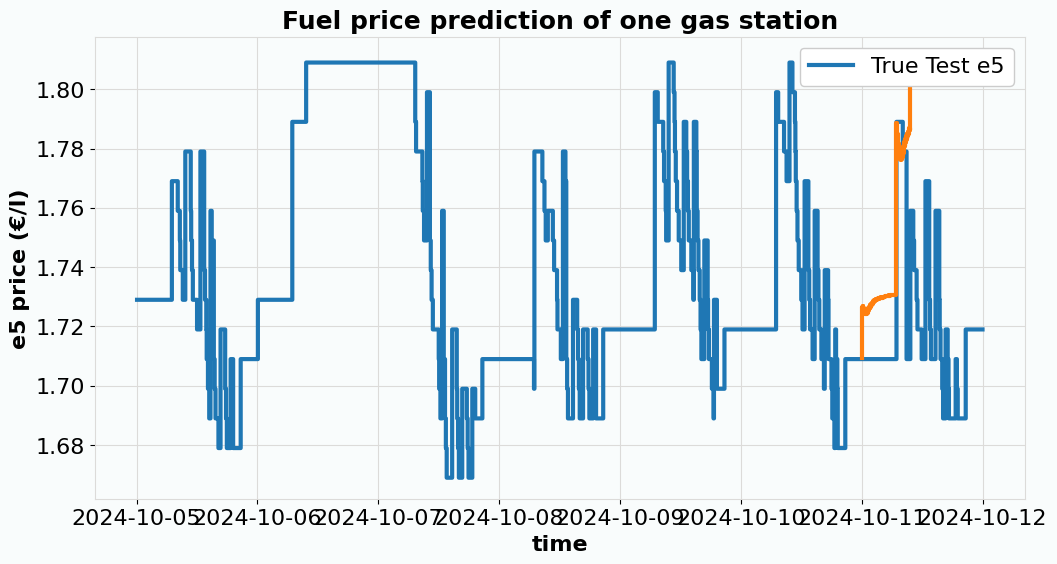

Successfully processed df05

Processing dataset: df06
Error in df06: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (288,) + inhomogeneous part.

Processing dataset: df07


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


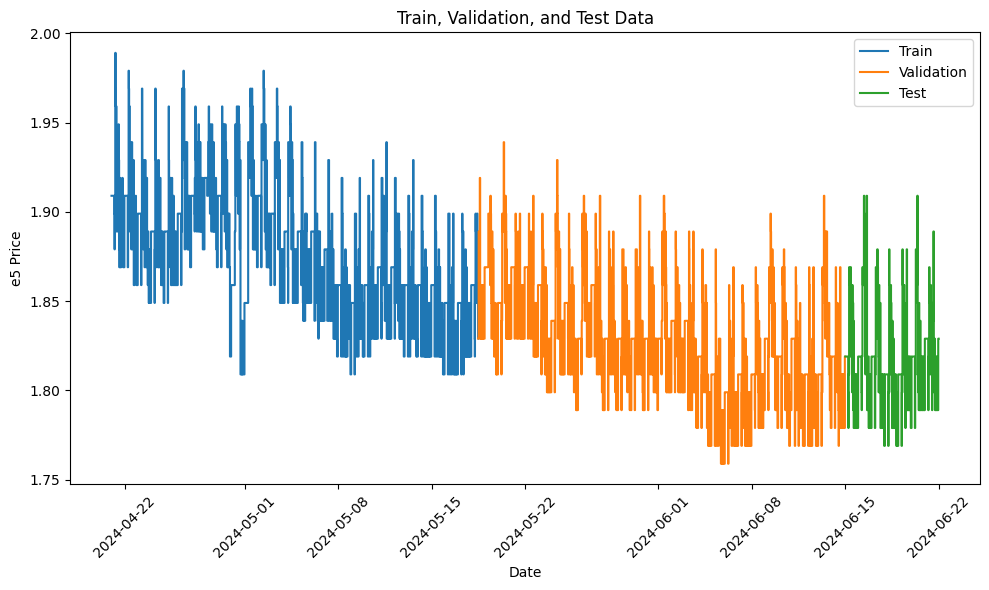

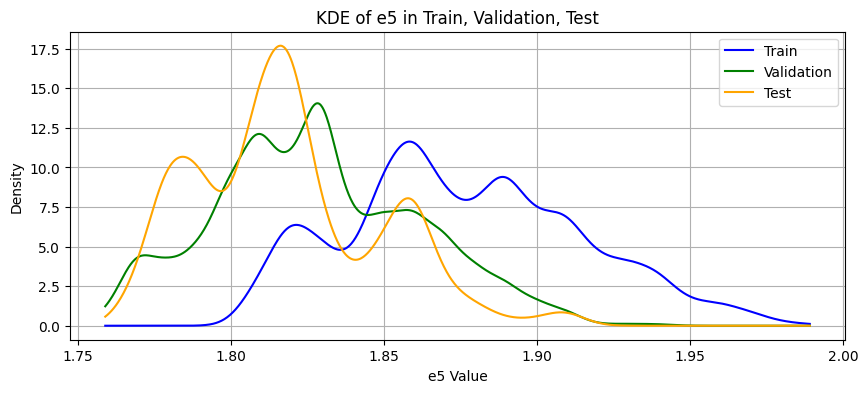

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0309 - val_loss: 0.0081
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0049 - val_loss: 0.0069
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0043 - val_loss: 0.0059
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0043 - val_loss: 0.0071
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0038 - val_loss: 0.0057
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0037 - val_loss: 0.0058
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0037 - val_loss: 0.0058
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0037 - val_loss: 0.0062
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0041 - val_loss: 0.0063
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0039 - val_loss: 0.0070
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0041 - val_loss: 0.0064
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
                     Predicted E5
datetime                         
2024-06-21 00:00:00      1.815340
2024-06-21 00:05:00      1.816595
2024-06-21 00:10:00      1.816136
2024-06-21 00:15:00      1.817066
2024-06-21 00:20:00      1.816973


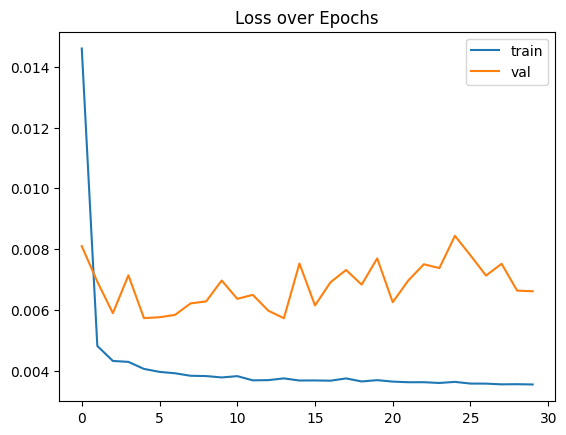

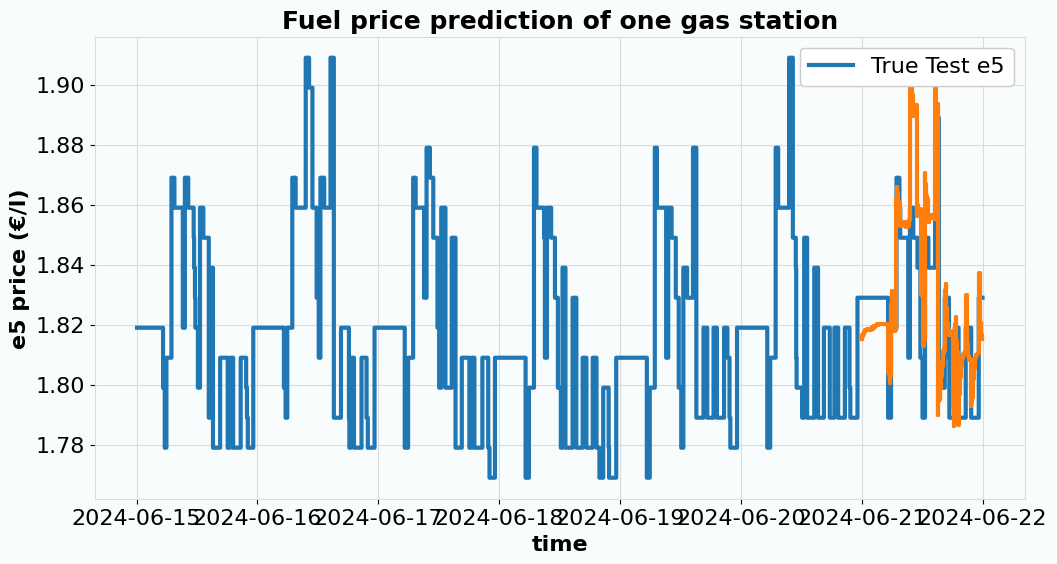

Successfully processed df07

Processing dataset: df08


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


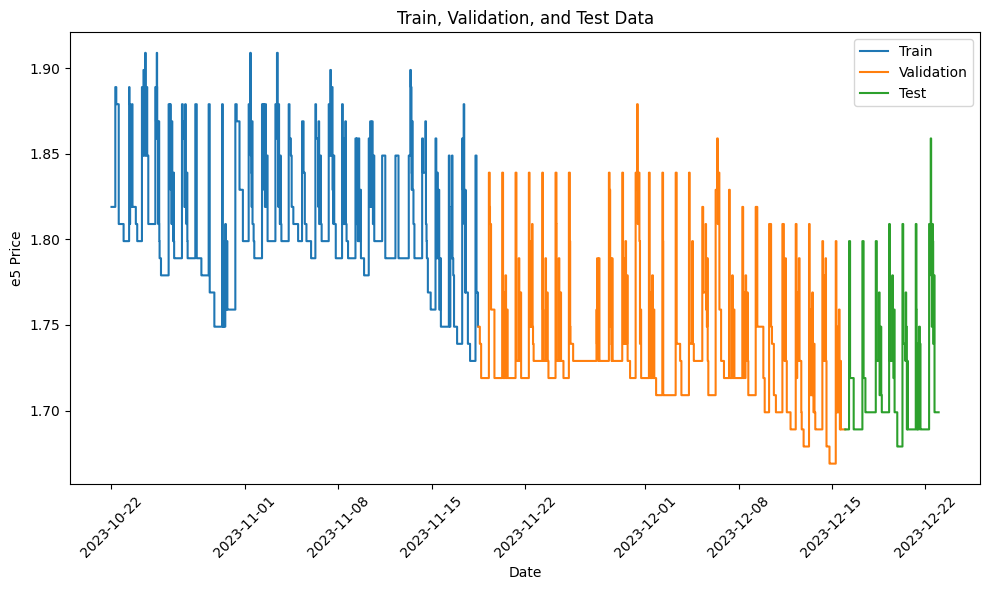

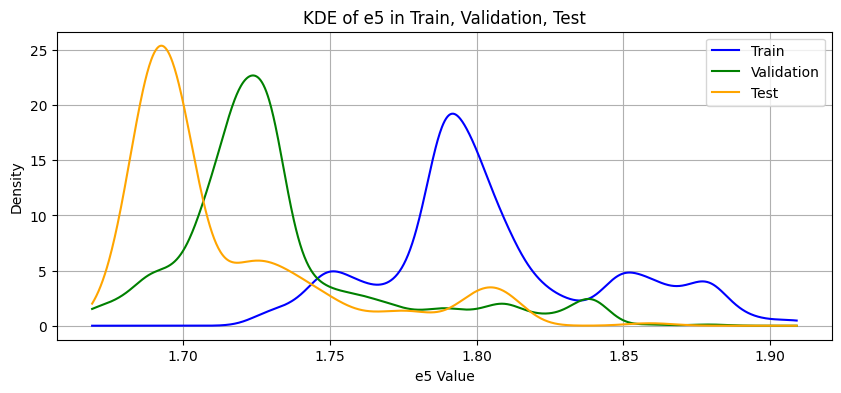

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0186 - val_loss: 0.0112
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0029 - val_loss: 0.0092
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0029 - val_loss: 0.0083
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0026 - val_loss: 0.0091
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0028 - val_loss: 0.0089
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0026 - val_loss: 0.0083
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0028 - val_loss: 0.0088
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0028 - val_loss: 0.0084
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0025 - val_loss: 0.0110
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0022 - val_loss: 0.0096
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0022 - val_loss: 0.0097
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2023-12-22 00:00:00      1.726944
2023-12-22 00:05:00      1.726943
2023-12-22 00:10:00      1.726941
2023-12-22 00:15:00      1.726941
2023-12-22 00:20:00      1.726939


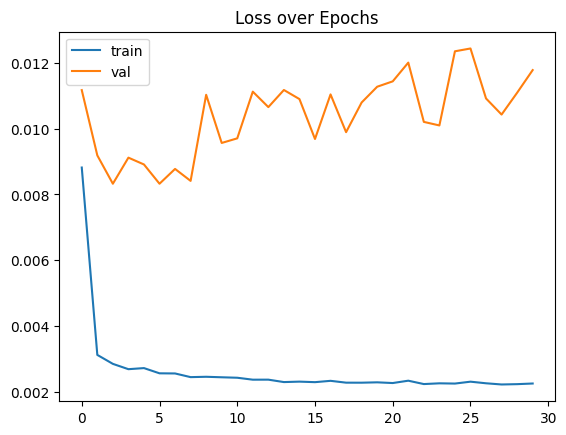

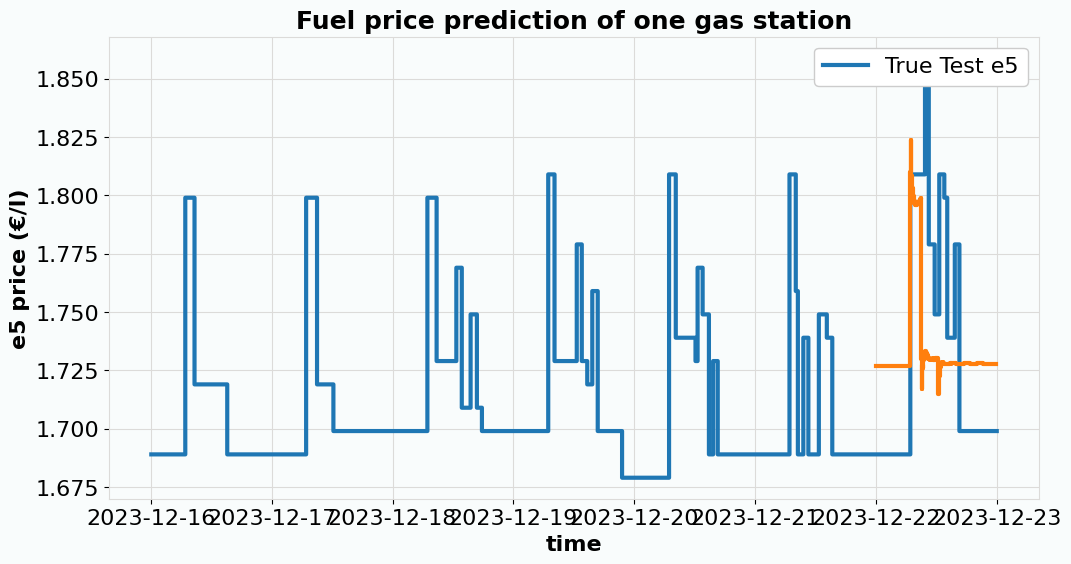

Successfully processed df08

Processing dataset: df09


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


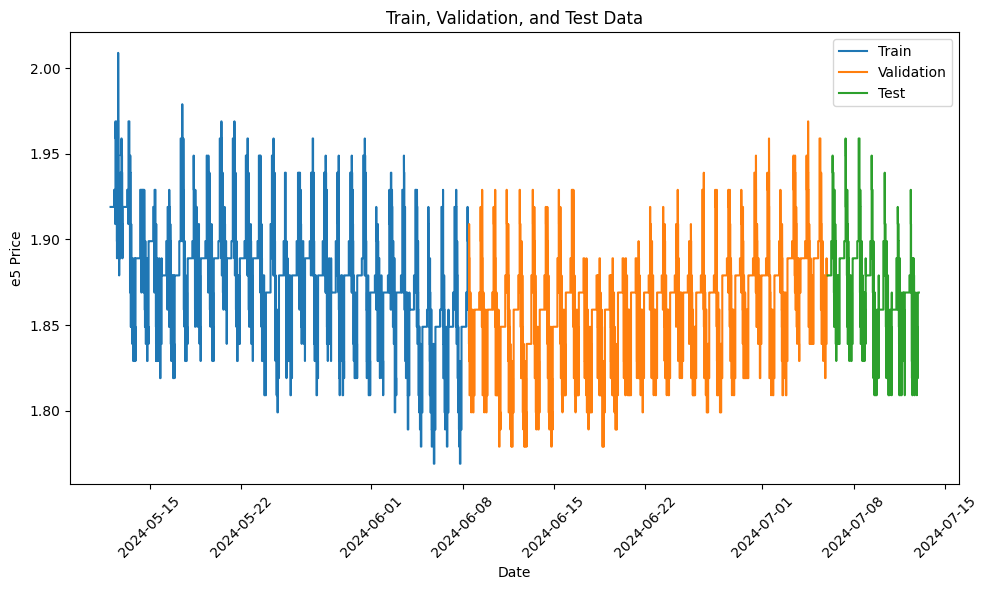

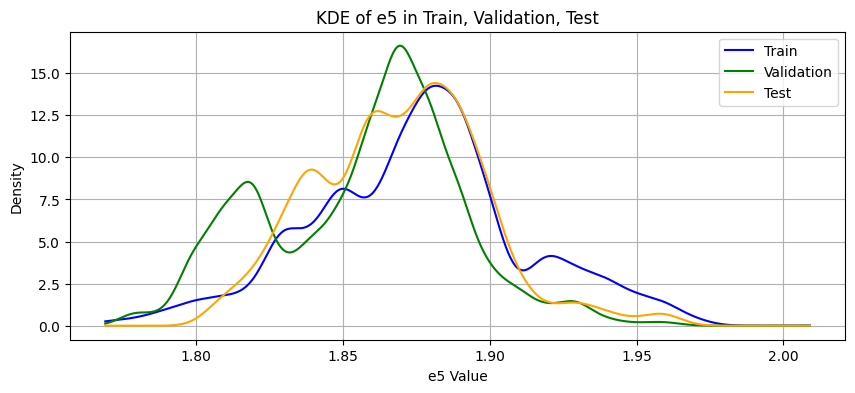

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0207 - val_loss: 0.0034
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
                     Predicted E5
datetime                         
2024-07-12 00:00:00      1.885901
2024-07-12 00:05:00      1.882815
2024-07-12 00:10:00      1.884752
2024-07-12 00:15:00      1.882077
2024-07-12 00:20:00      1.884133


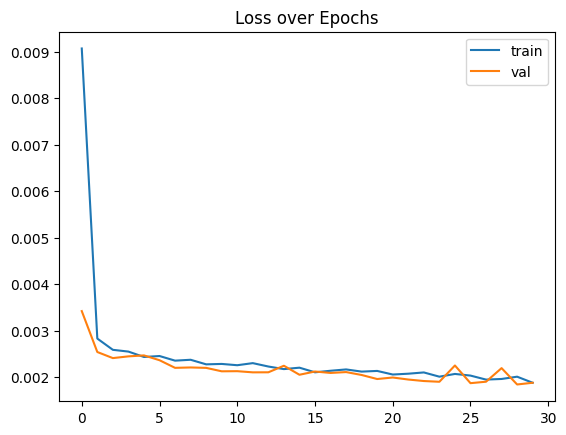

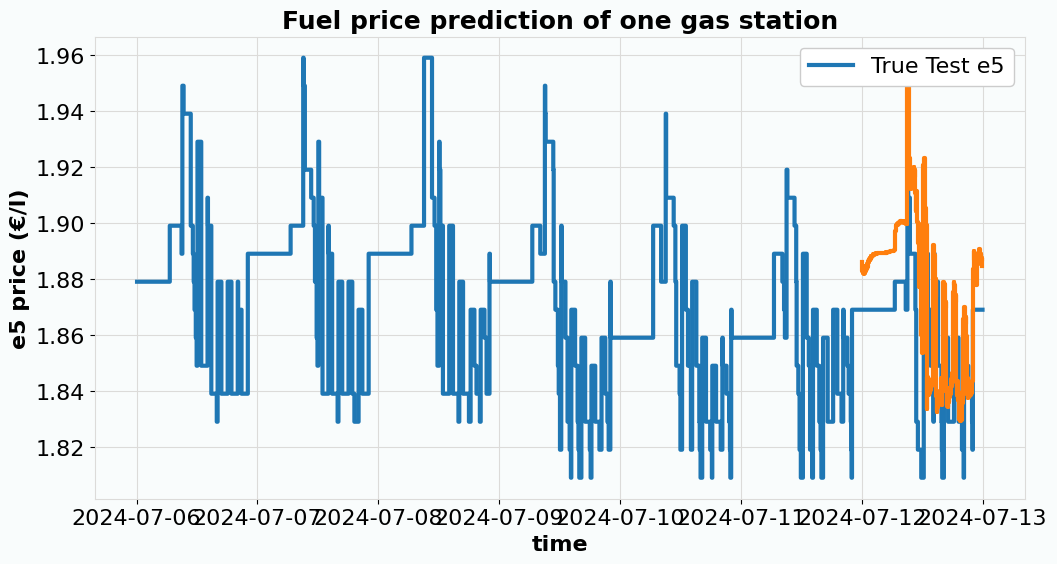

Successfully processed df09

Processing dataset: df10


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


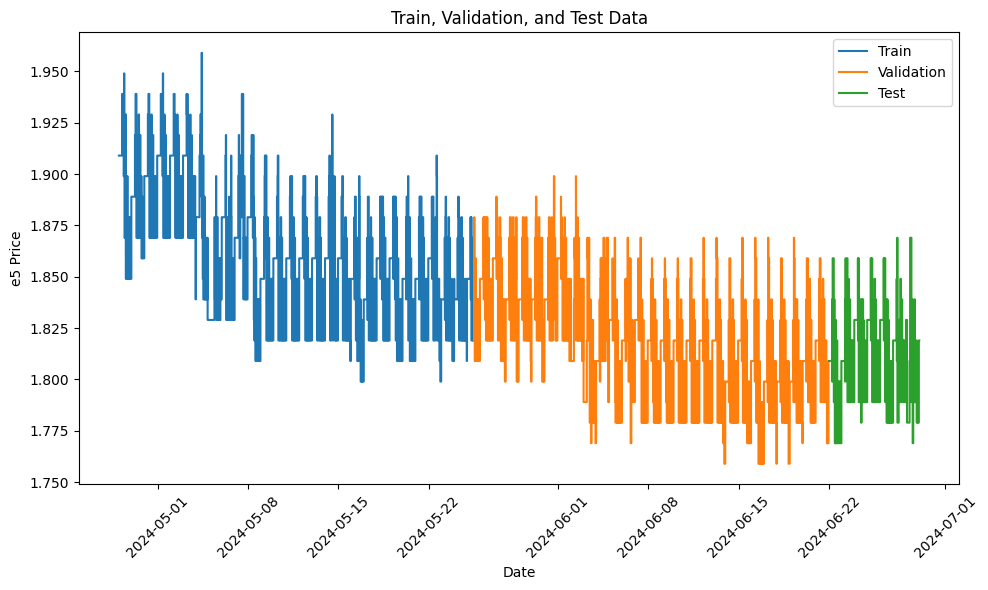

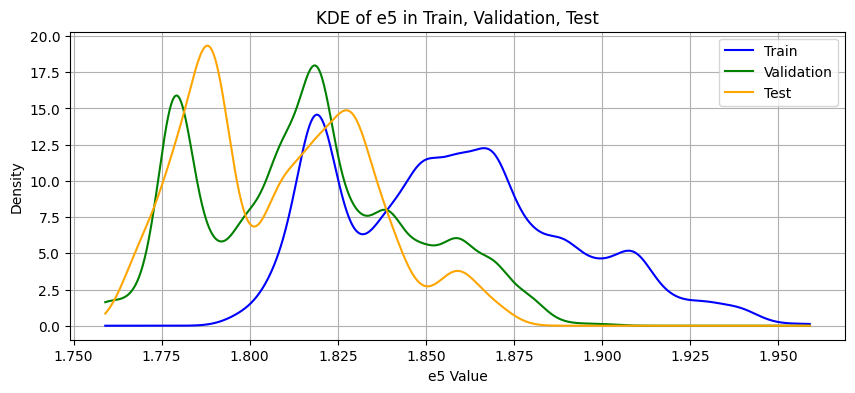

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0287 - val_loss: 0.0080
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0055 - val_loss: 0.0068
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0050 - val_loss: 0.0065
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0048 - val_loss: 0.0062
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0049 - val_loss: 0.0068
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0044 - val_loss: 0.0061
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0043 - val_loss: 0.0061
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0037 - val_loss: 0.0066
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0042 - val_loss: 0.0063
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
                     Predicted E5
datetime                         
2024-06-28 00:00:00      1.814557
2024-06-28 00:05:00      1.814665
2024-06-28 00:10:00      1.814638
2024-06-28 00:15:00      1.814518
2024-06-28 00:20:00      1.814588


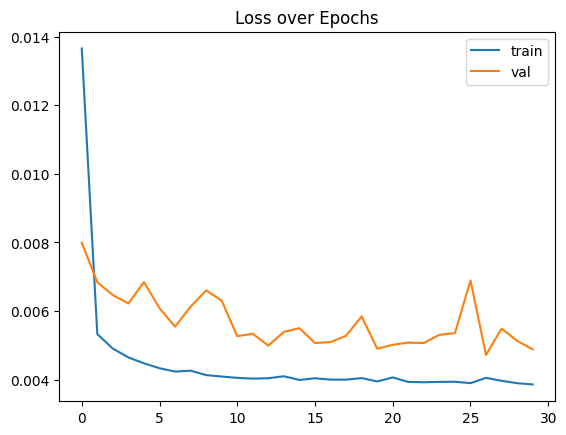

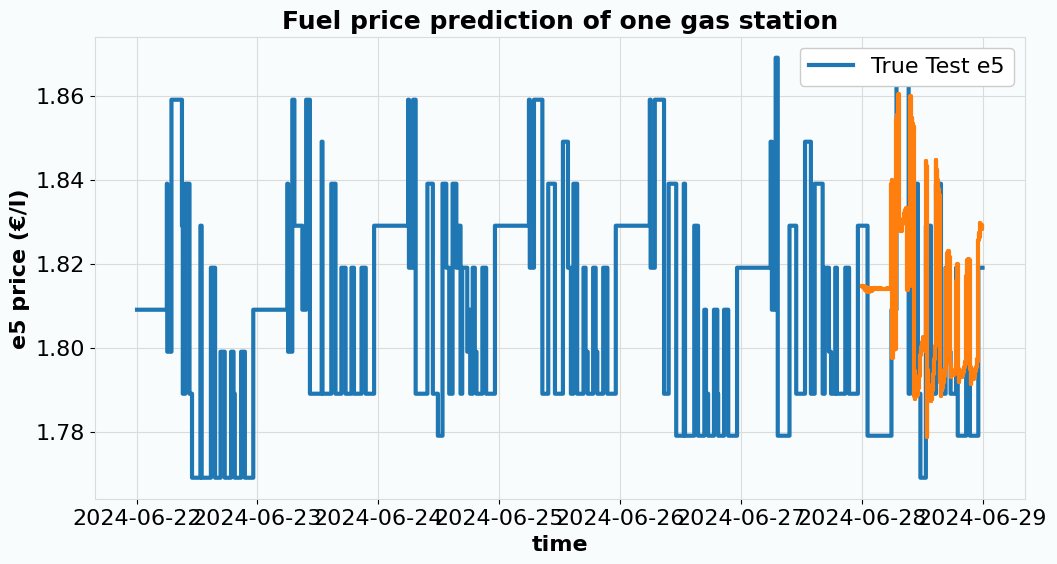

Successfully processed df10

Processing dataset: df11


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


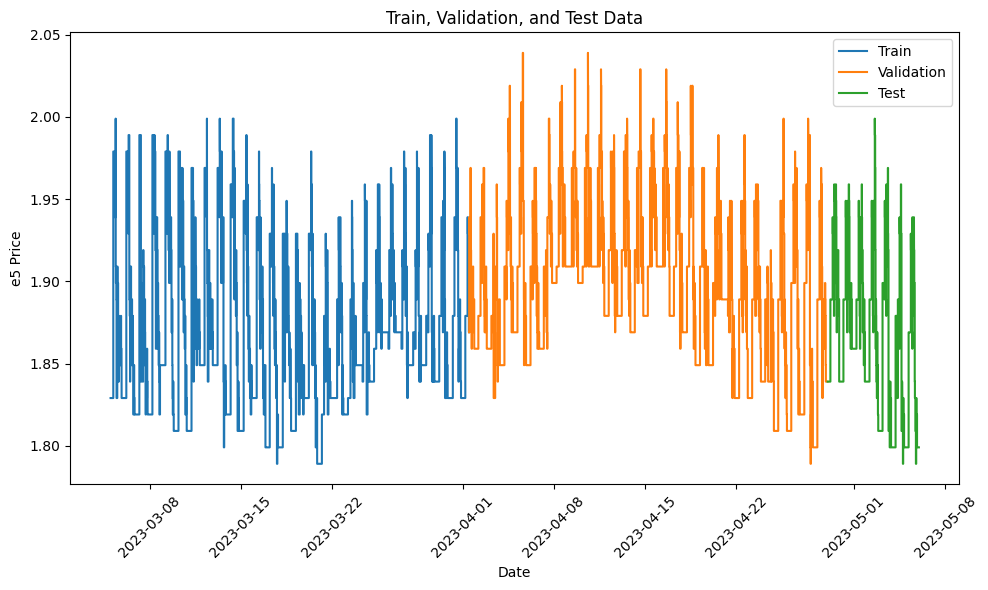

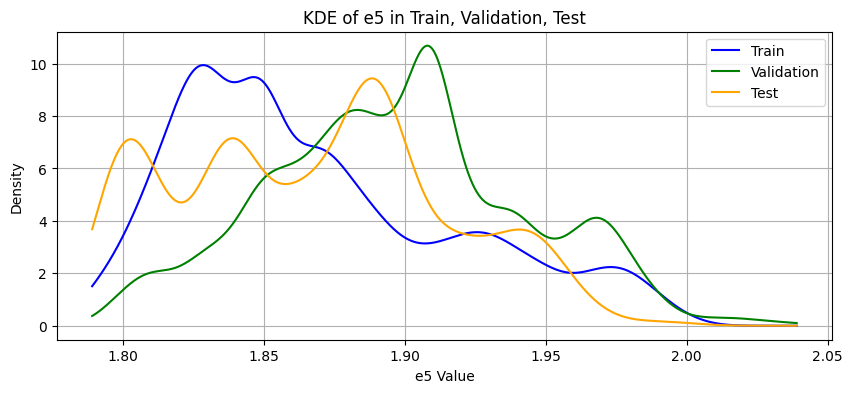

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0312 - val_loss: 0.0044
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
                     Predicted E5
datetime                         
2023-05-05 00:00:00      1.838309
2023-05-05 00:05:00      1.838649
2023-05-05 00:10:00      1.837976
2023-05-05 00:15:00      1.838354
2023-05-05 00:20:00      1.837698


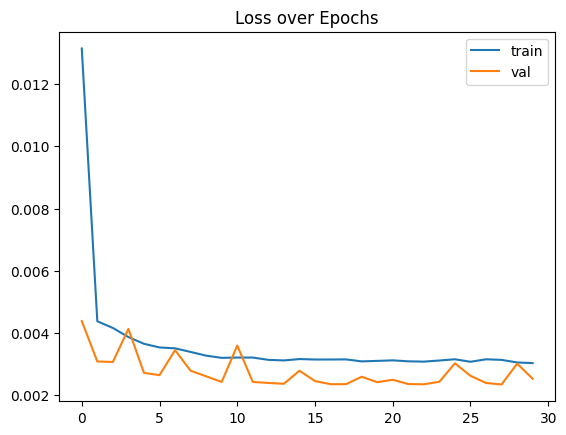

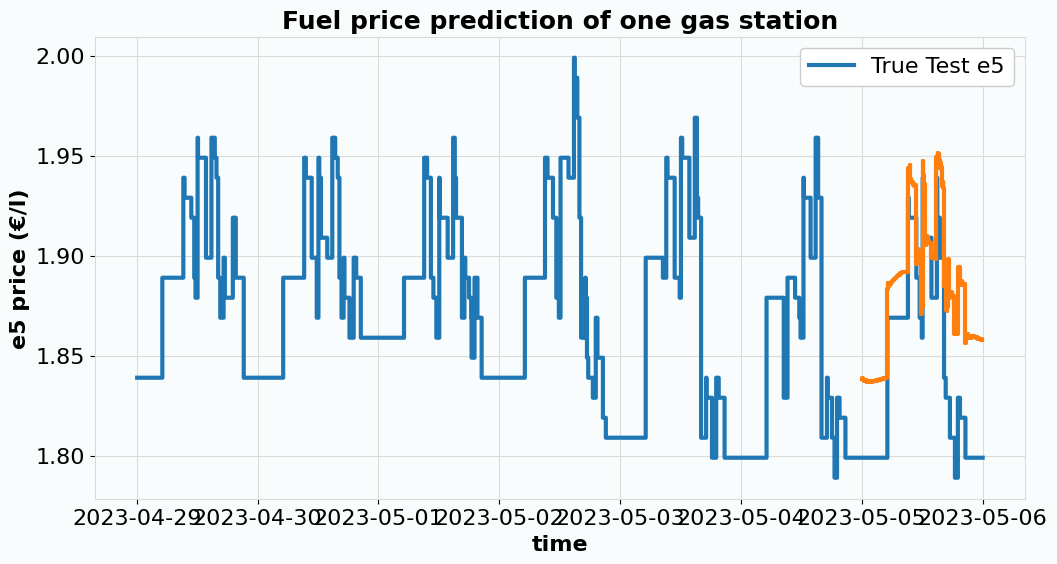

Successfully processed df11

Processing dataset: df12


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


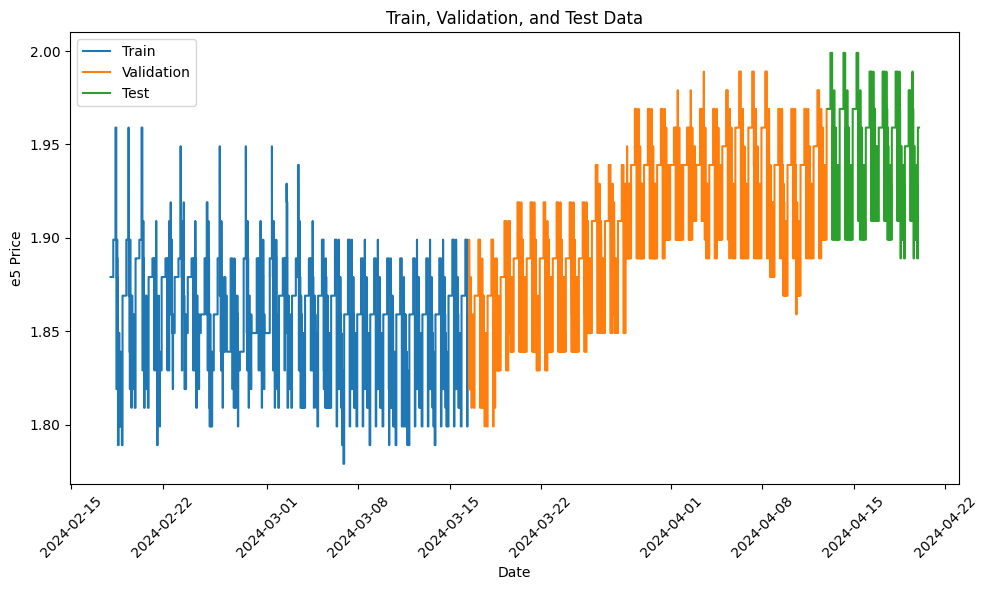

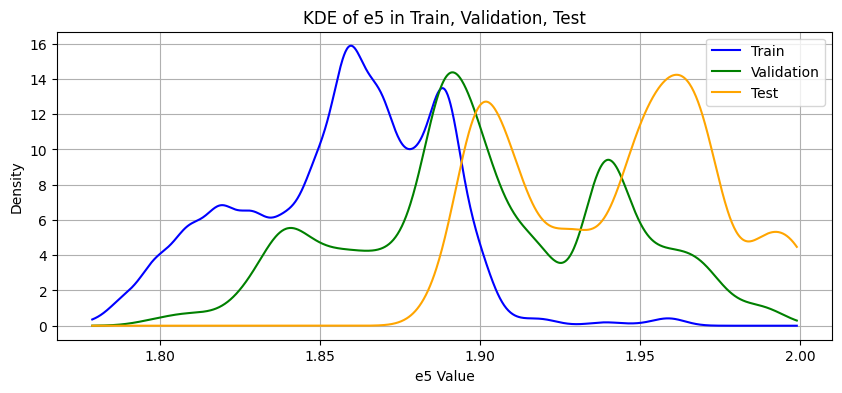

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0305 - val_loss: 0.0079
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0049 - val_loss: 0.0052
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0042 - val_loss: 0.0045
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0041 - val_loss: 0.0060
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2024-04-19 00:00:00      1.948544
2024-04-19 00:05:00      1.947178
2024-04-19 00:10:00      1.948001
2024-04-19 00:15:00      1.946851
2024-04-19 00:20:00      1.947571


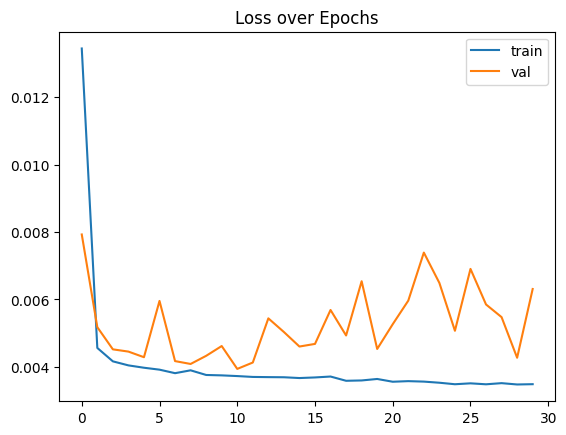

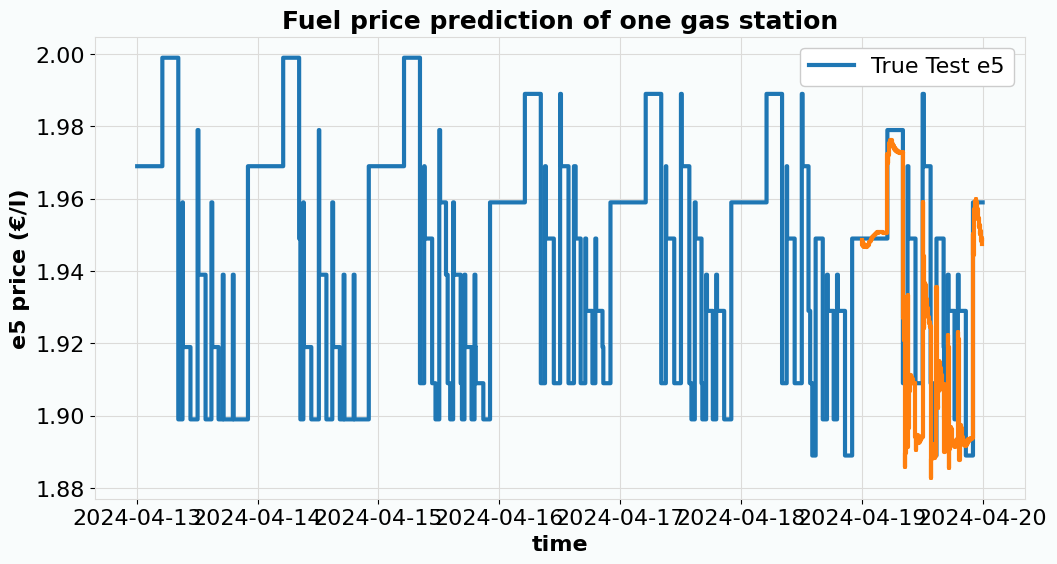

Successfully processed df12

Processing dataset: df13


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


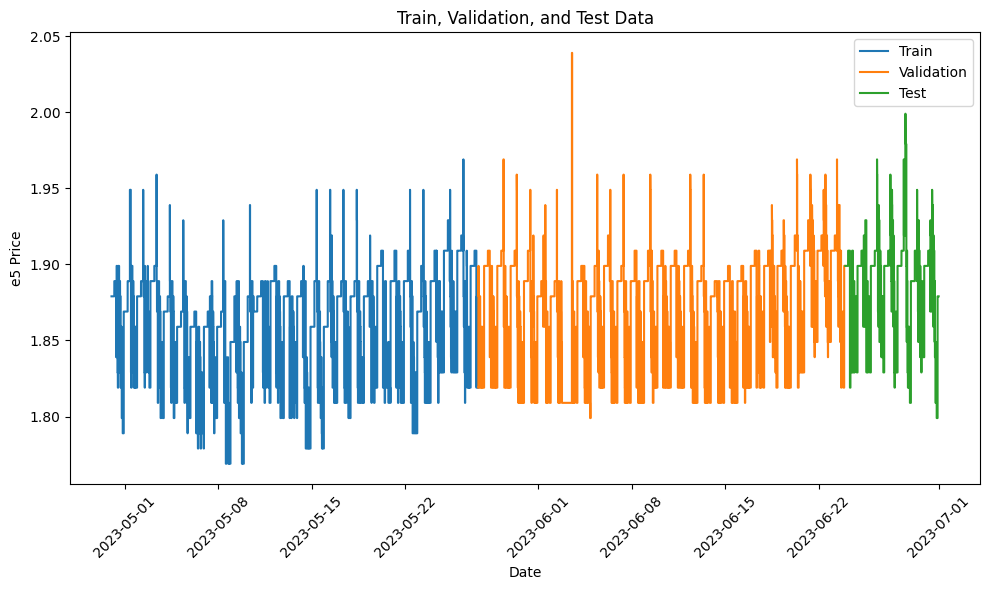

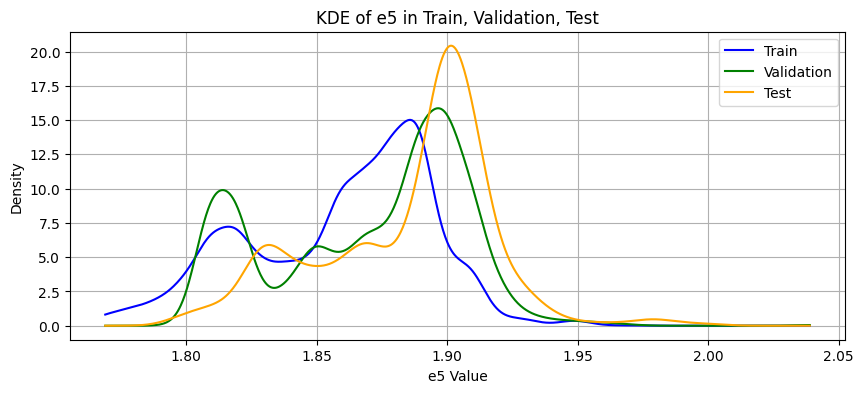

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0187 - val_loss: 0.0049
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0039 - val_loss: 0.0054
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2023-06-30 00:00:00      1.892374
2023-06-30 00:05:00      1.892051
2023-06-30 00:10:00      1.893434
2023-06-30 00:15:00      1.893176
2023-06-30 00:20:00      1.894476


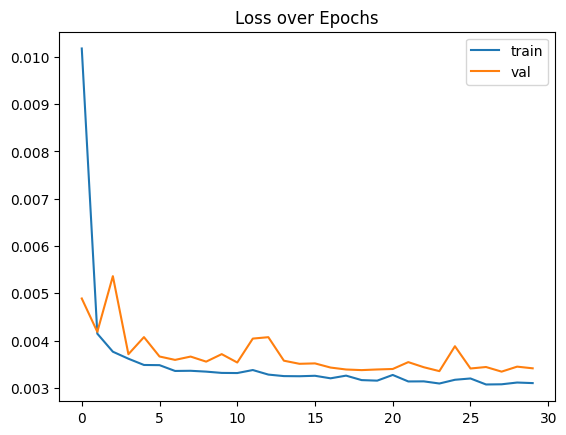

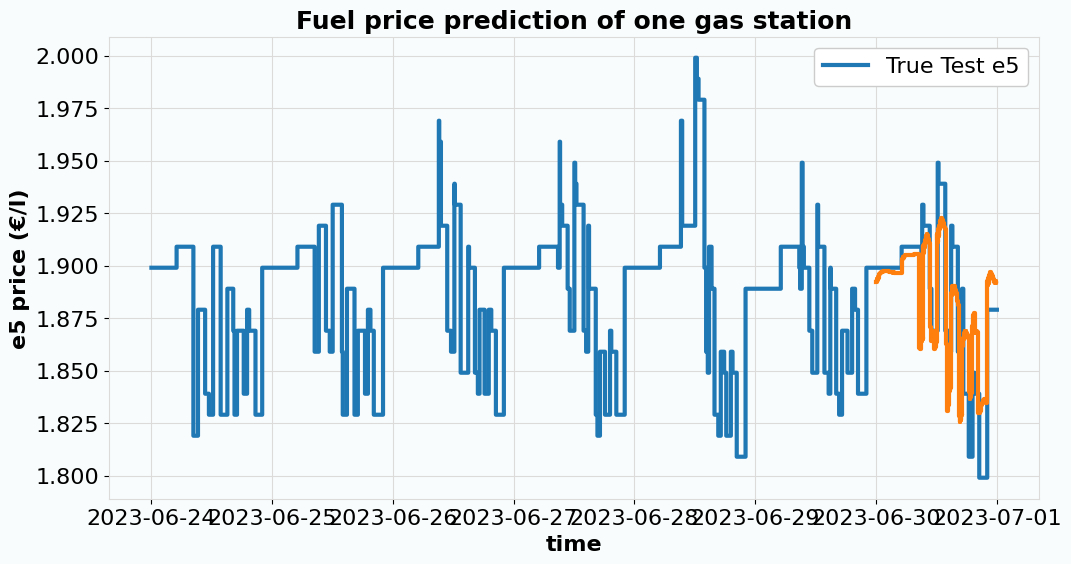

Successfully processed df13

Processing dataset: df14


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


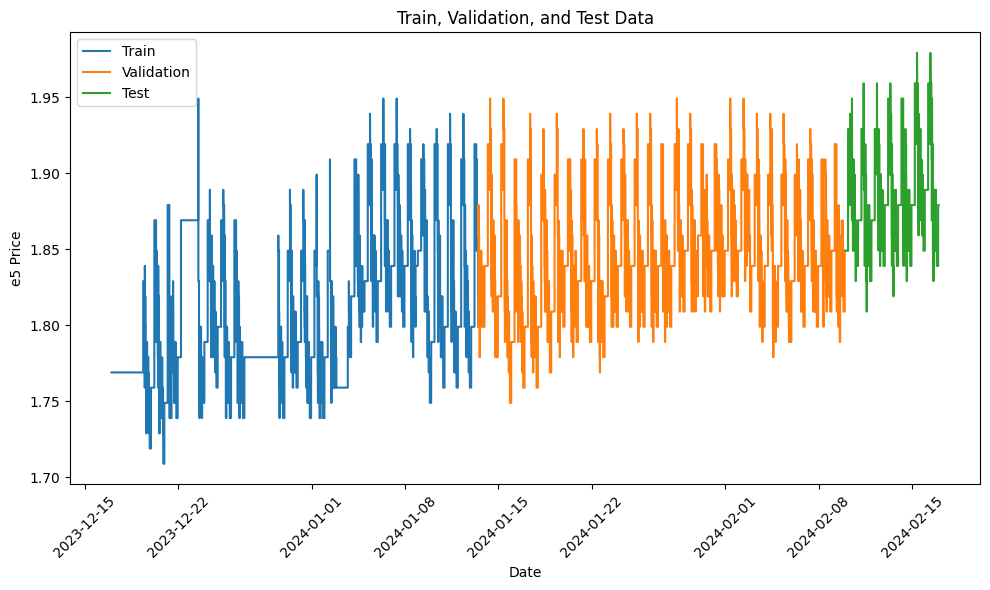

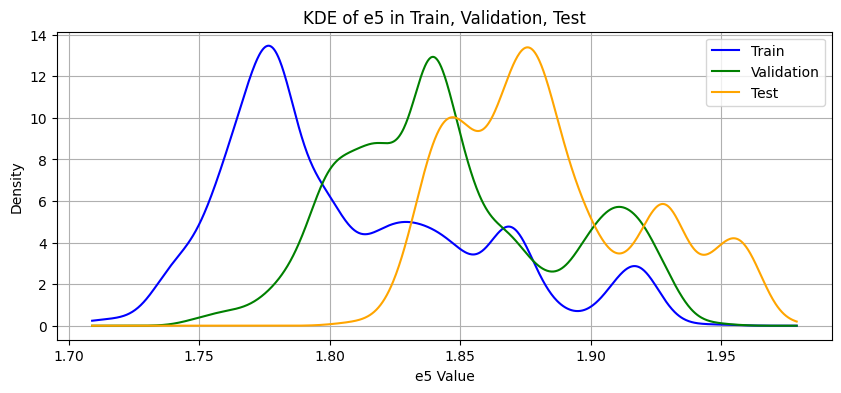

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0285 - val_loss: 0.0041
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2024-02-16 00:00:00      1.871554
2024-02-16 00:05:00      1.871376
2024-02-16 00:10:00      1.871446
2024-02-16 00:15:00      1.871323
2024-02-16 00:20:00      1.871394


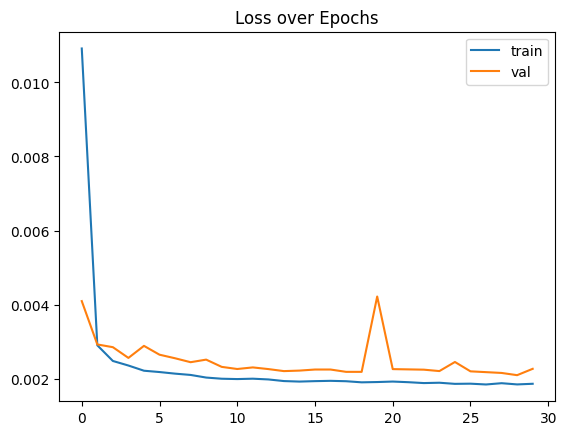

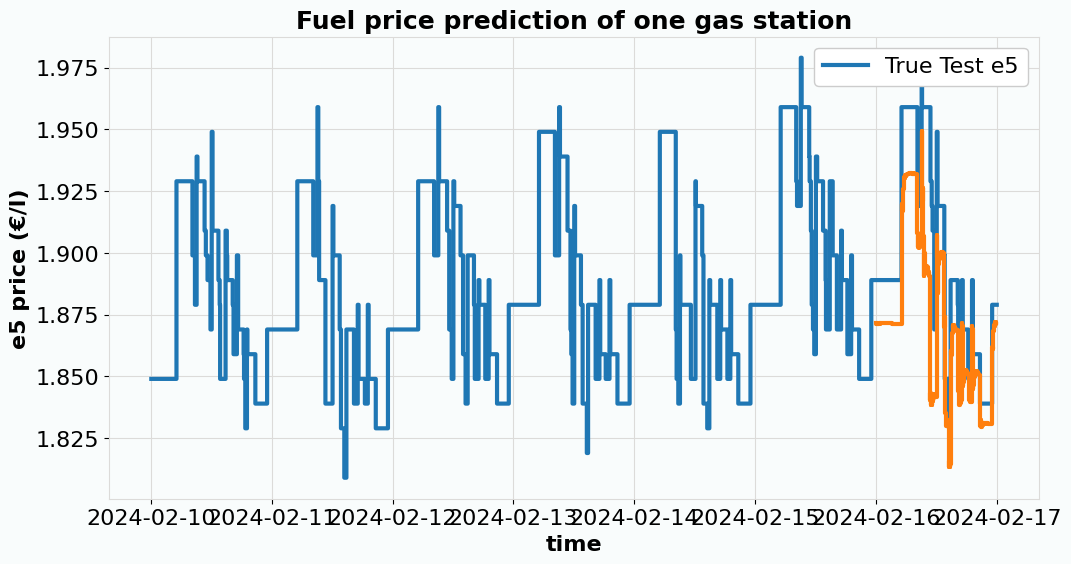

Successfully processed df14

Processing dataset: df15


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


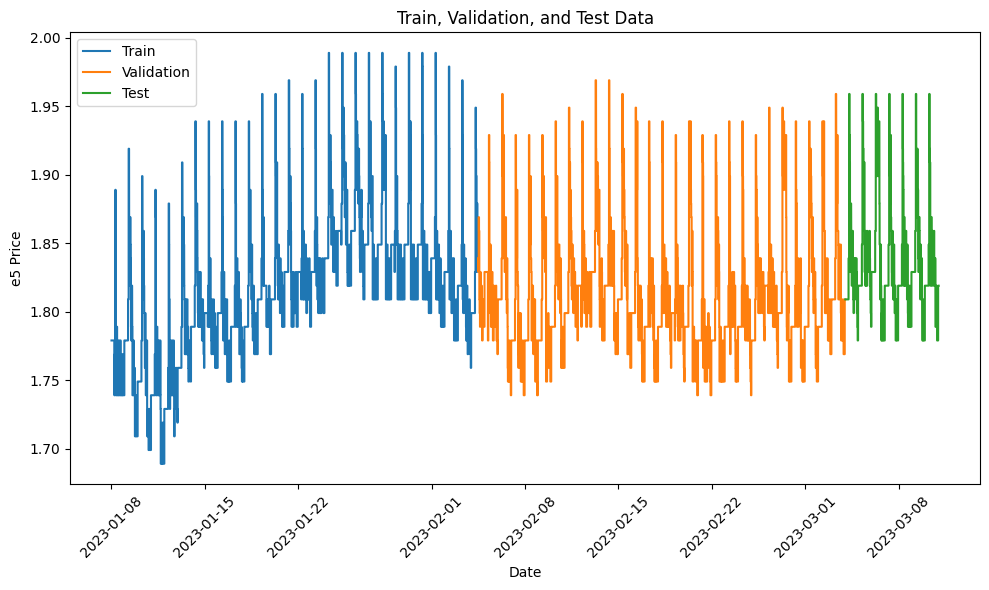

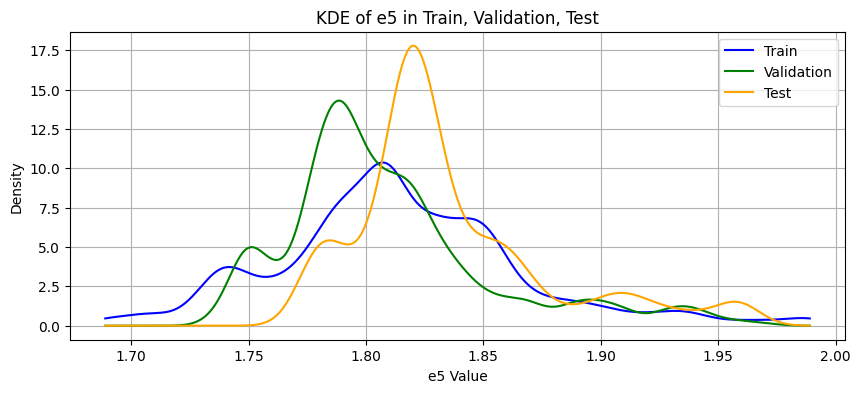

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0200 - val_loss: 0.0025
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2023-03-10 00:00:00      1.815175
2023-03-10 00:05:00      1.814996
2023-03-10 00:10:00      1.815436
2023-03-10 00:15:00      1.815326
2023-03-10 00:20:00      1.815720


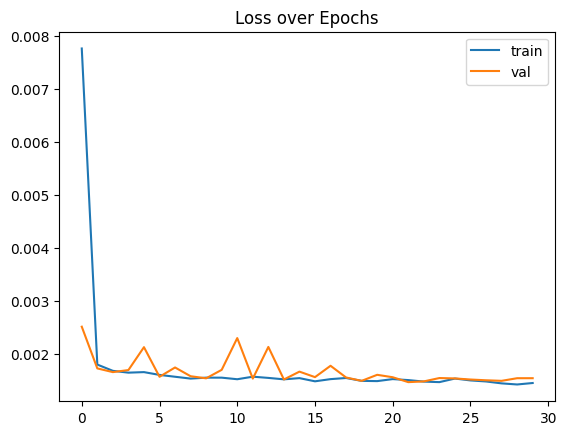

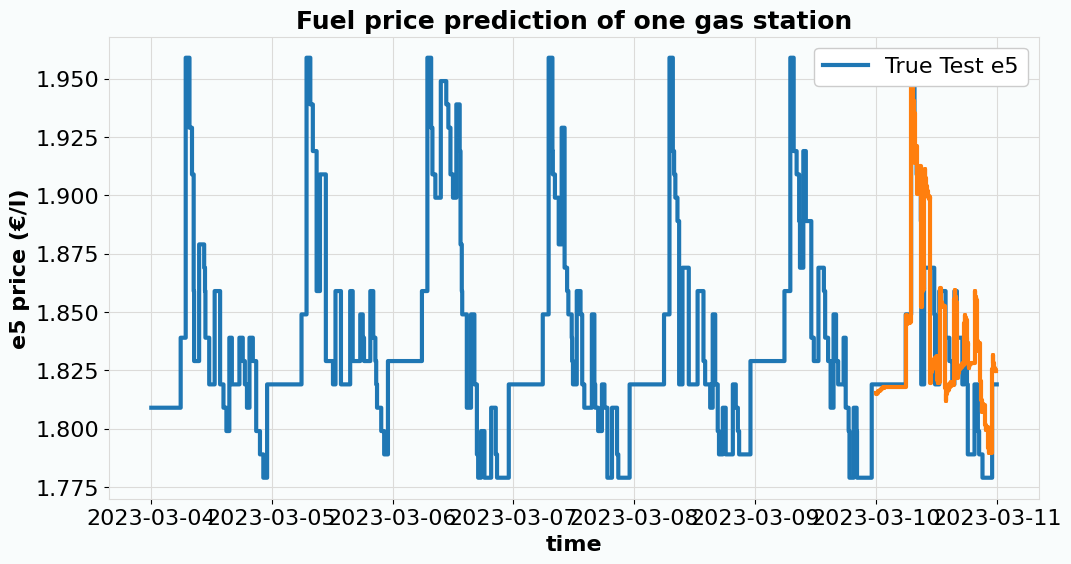

Successfully processed df15

Processing dataset: df16


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


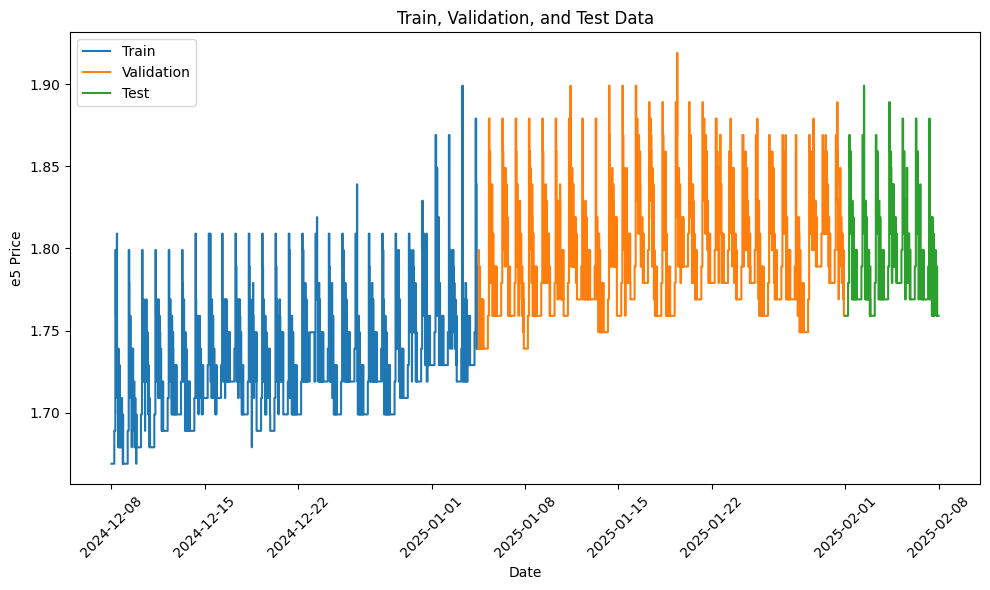

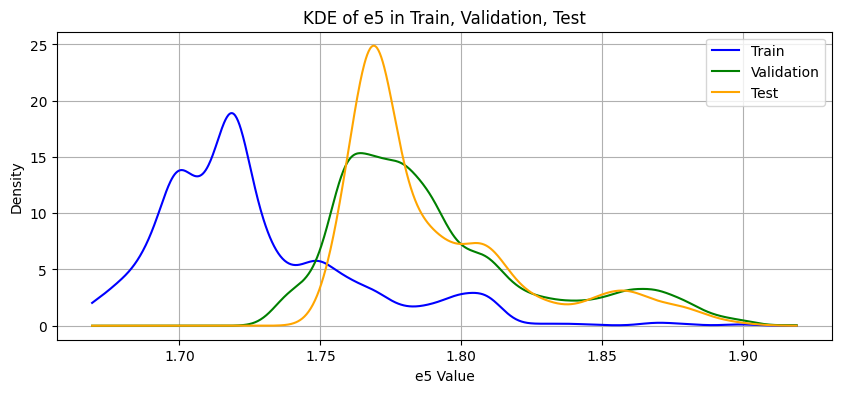

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0141 - val_loss: 0.0088
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2025-02-07 00:00:00      1.762159
2025-02-07 00:05:00      1.762235
2025-02-07 00:10:00      1.761976
2025-02-07 00:15:00      1.762047
2025-02-07 00:20:00      1.761852


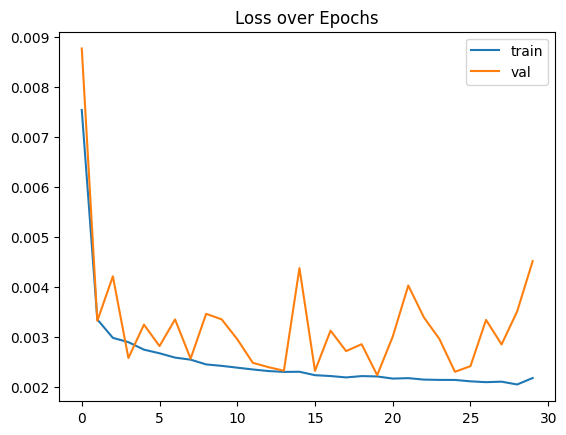

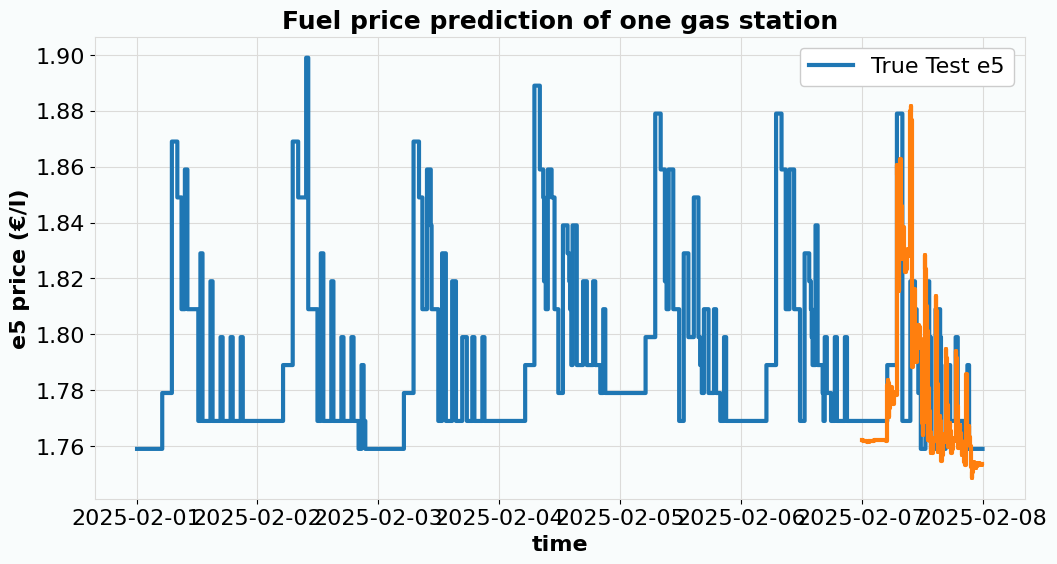

Successfully processed df16

Processing dataset: df17


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


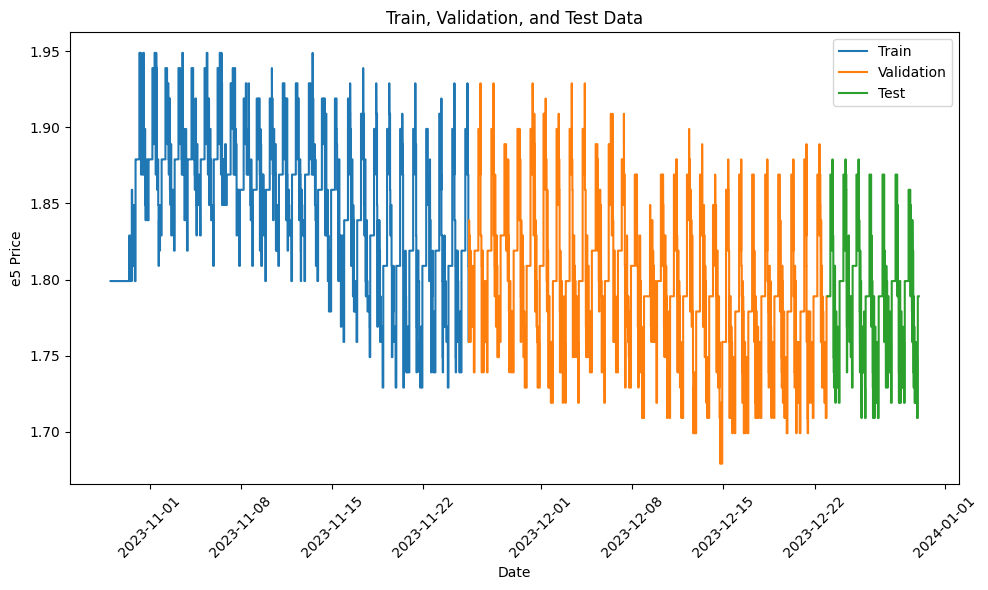

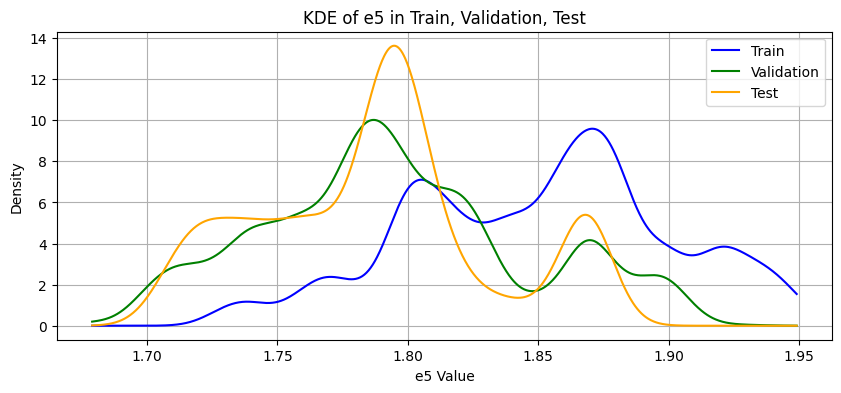

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0451 - val_loss: 0.0056
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
                     Predicted E5
datetime                         
2023-12-29 00:00:00      1.796744
2023-12-29 00:05:00      1.796953
2023-12-29 00:10:00      1.797023
2023-12-29 00:15:00      1.797138
2023-12-29 00:20:00      1.797221


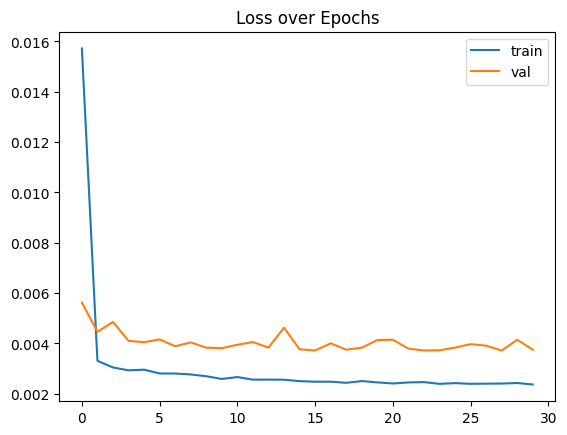

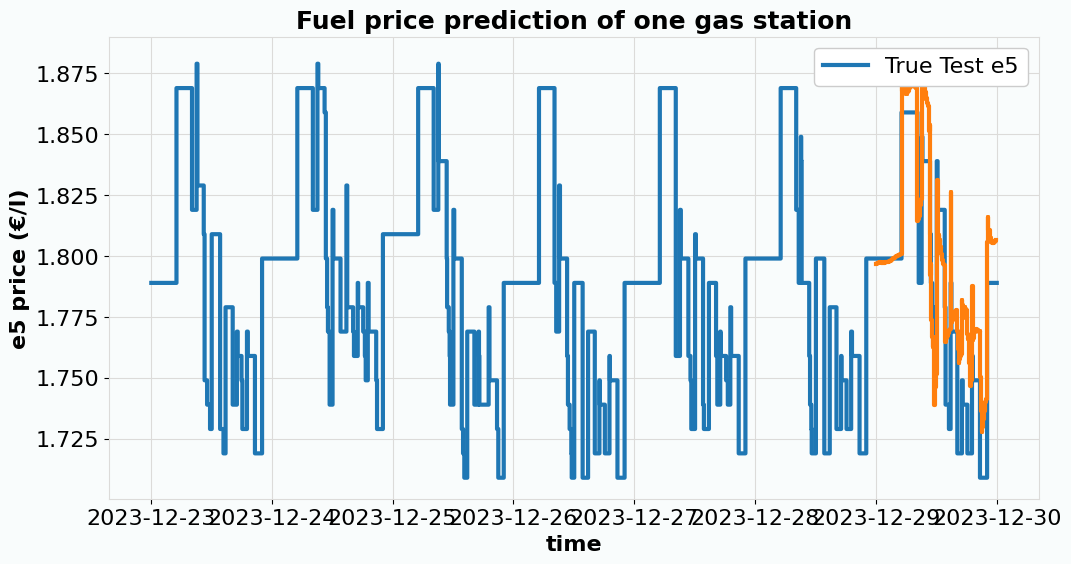

Successfully processed df17

Processing dataset: df18


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


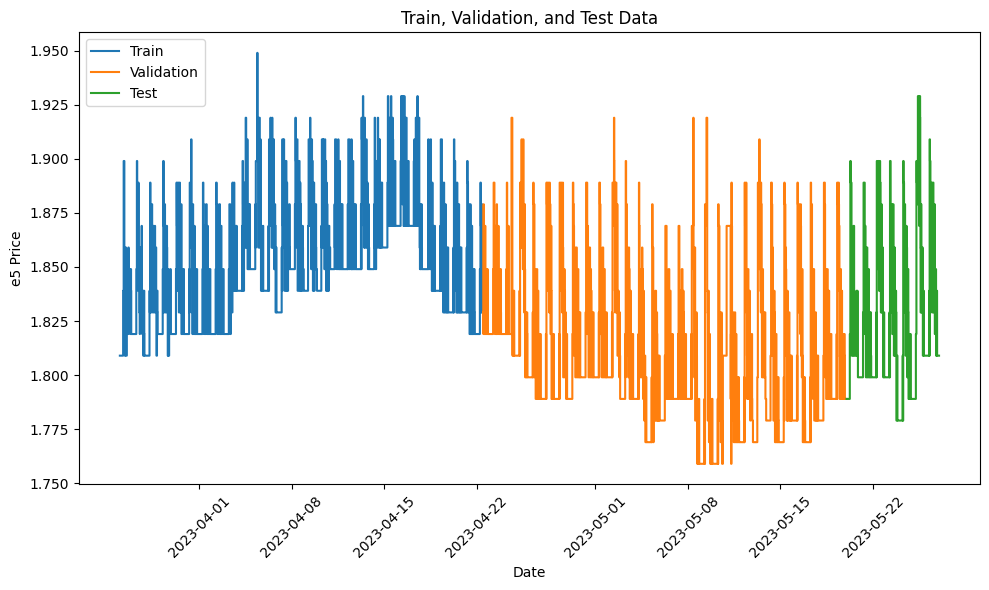

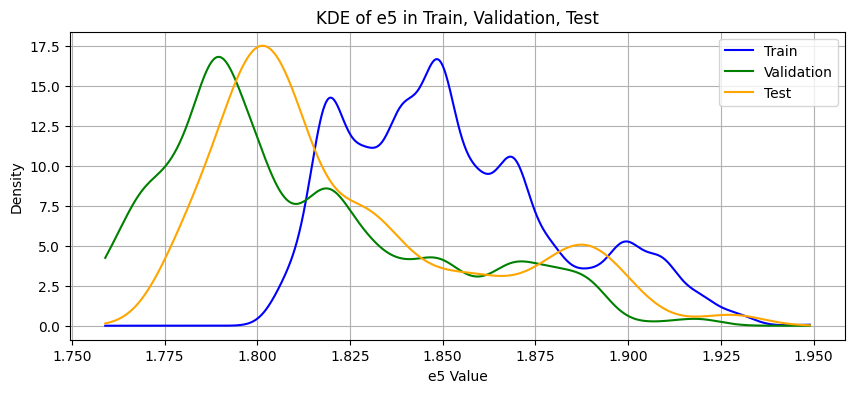

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0298 - val_loss: 0.0172
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0047 - val_loss: 0.0146
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0043 - val_loss: 0.0151
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0047 - val_loss: 0.0140
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0042 - val_loss: 0.0142
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0042 - val_loss: 0.0138
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0043 - val_loss: 0.0158
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0045 - val_loss: 0.0163
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0043 - val_loss: 0.0152
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0046 - val_loss: 0.0157
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0045 - val_loss: 0.0193
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2023-05-26 00:00:00      1.806329
2023-05-26 00:05:00      1.805720
2023-05-26 00:10:00      1.806146
2023-05-26 00:15:00      1.805635
2023-05-26 00:20:00      1.805973


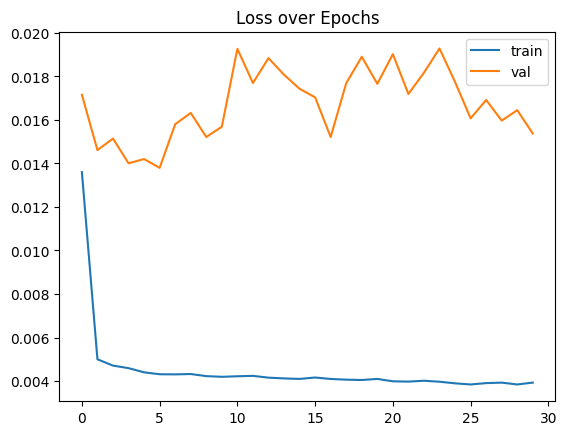

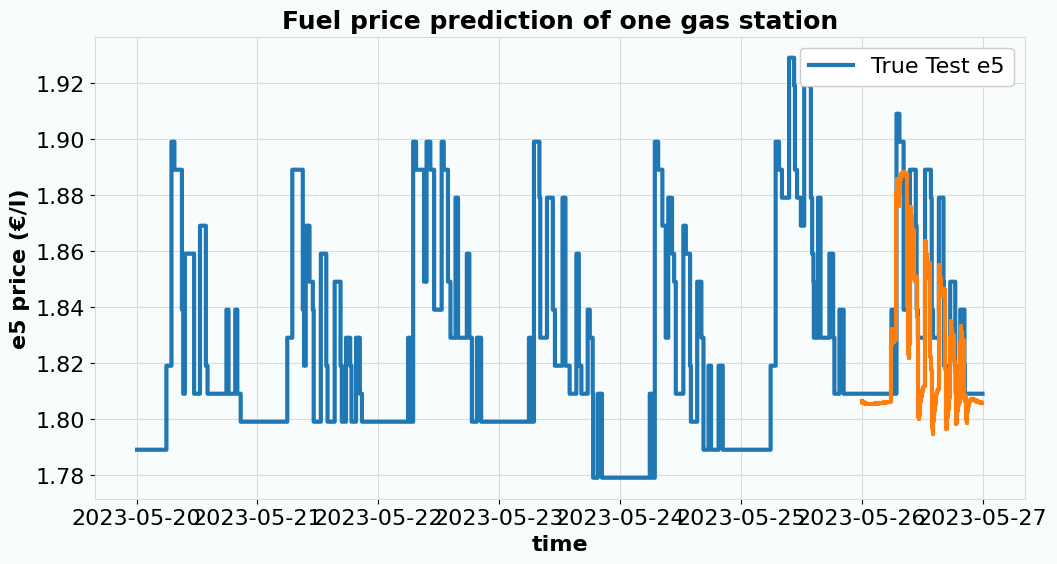

Successfully processed df18

Processing dataset: df19


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


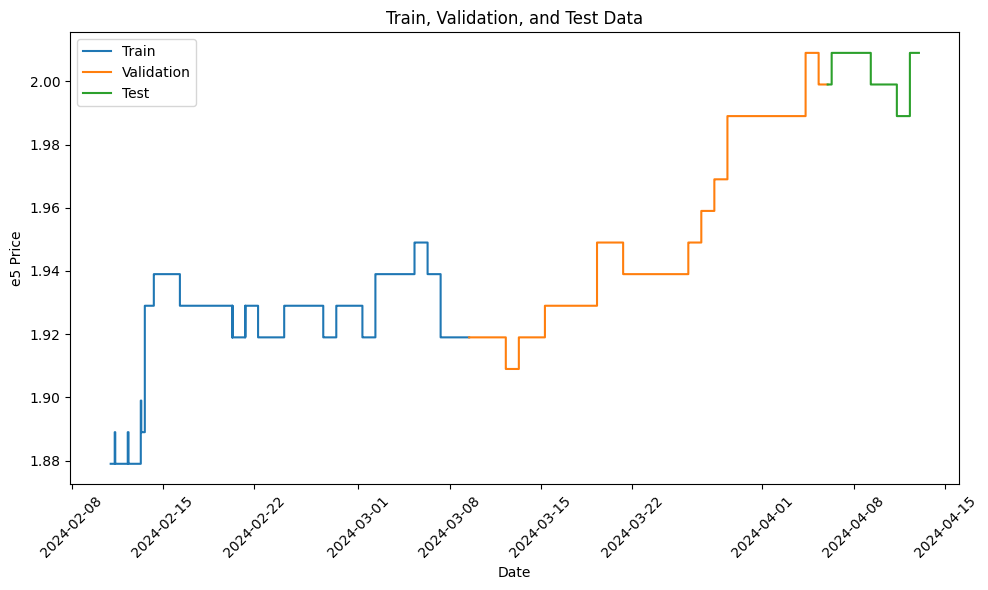

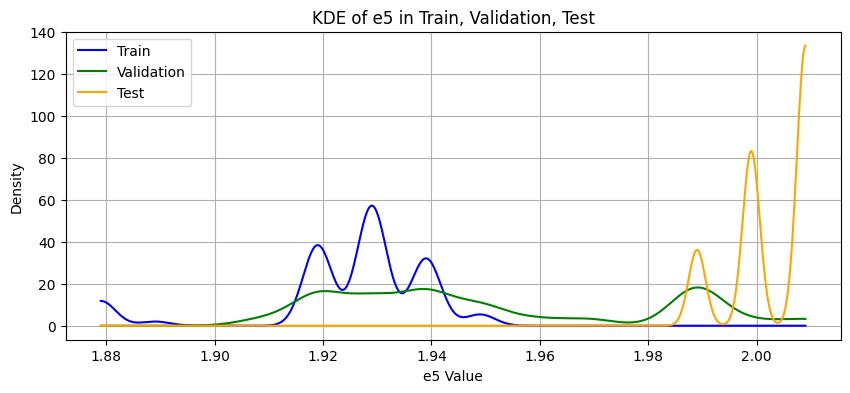

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0428 - val_loss: 0.0099
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 6.4375e-04 - val_loss: 0.0078
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 4.4883e-04 - val_loss: 0.0047
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 2.8499e-04 - val_loss: 0.0045
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 2.5840e-04 - val_loss: 0.0030
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 3.0381e-04 - val_loss: 0.0039
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 2.4368e-04 - val_loss: 0.0028
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 3.0443e-04 - val_loss: 0.0024
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 1.9116e-04 - val_loss: 0.0031
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 2.2989e-04 - val_loss: 0.0017
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 2.1317e-04 - val_loss: 0.0020


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
                     Predicted E5
datetime                         
2024-04-12 00:00:00      1.997251
2024-04-12 00:05:00      1.997251
2024-04-12 00:10:00      1.997251
2024-04-12 00:15:00      1.997251
2024-04-12 00:20:00      1.997251


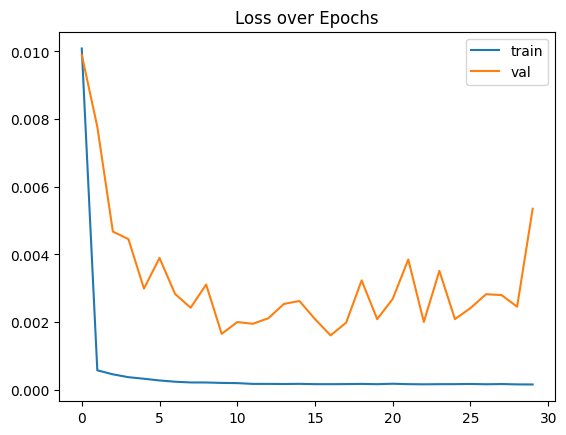

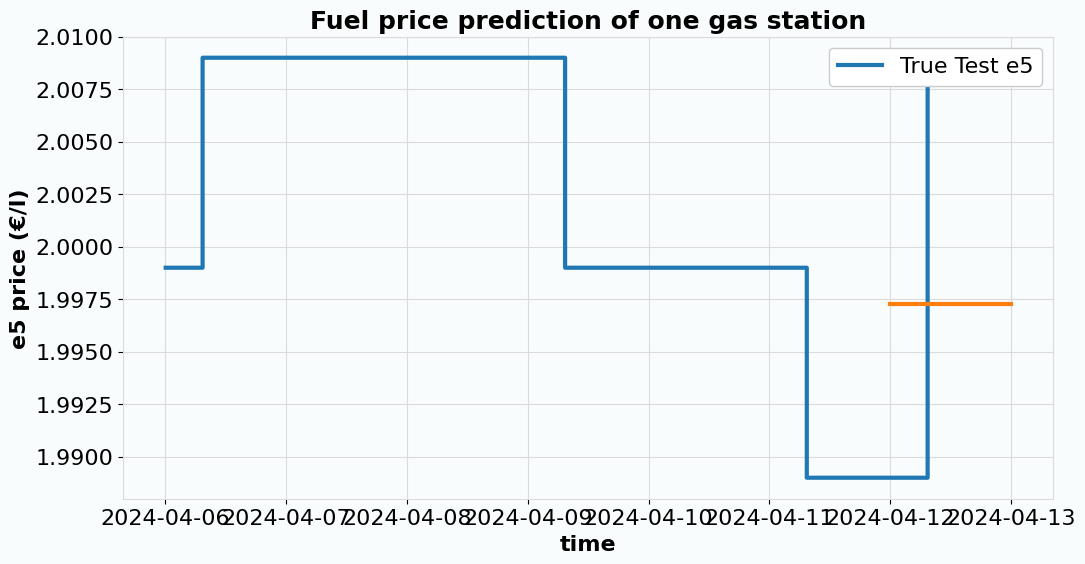

Successfully processed df19

Processing dataset: df20


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


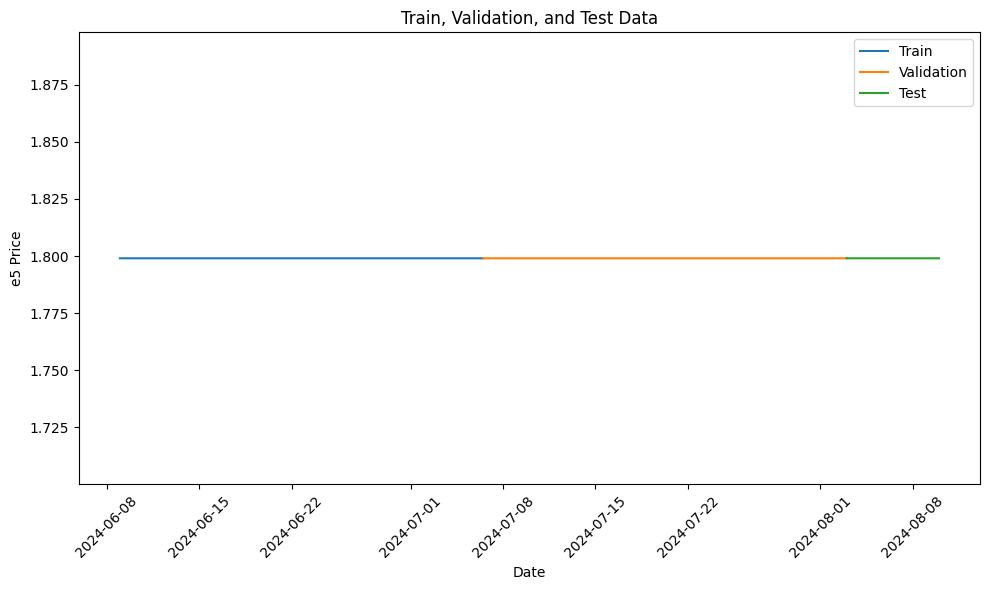

Error in df20: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

Processing dataset: df21


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


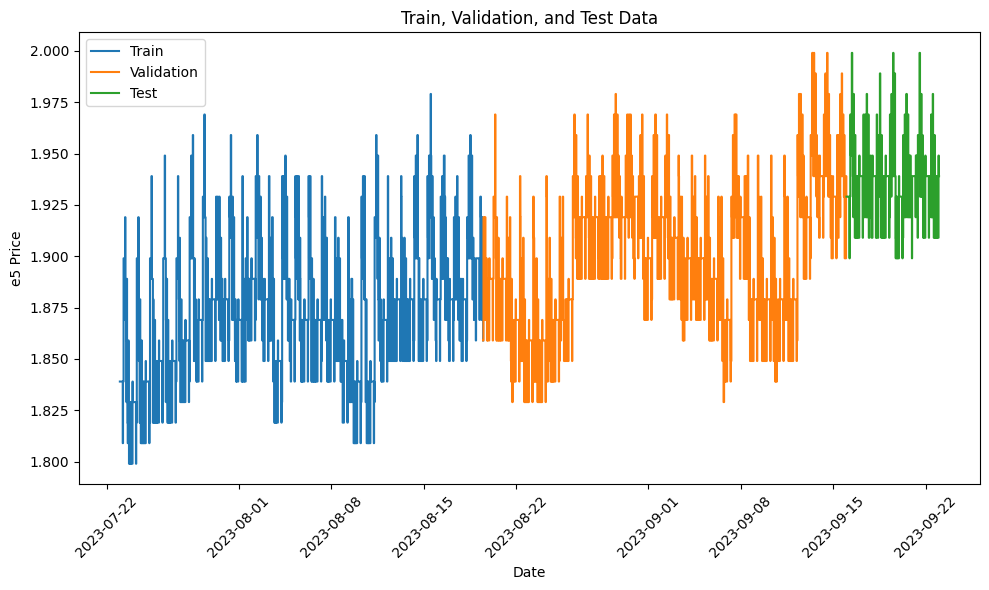

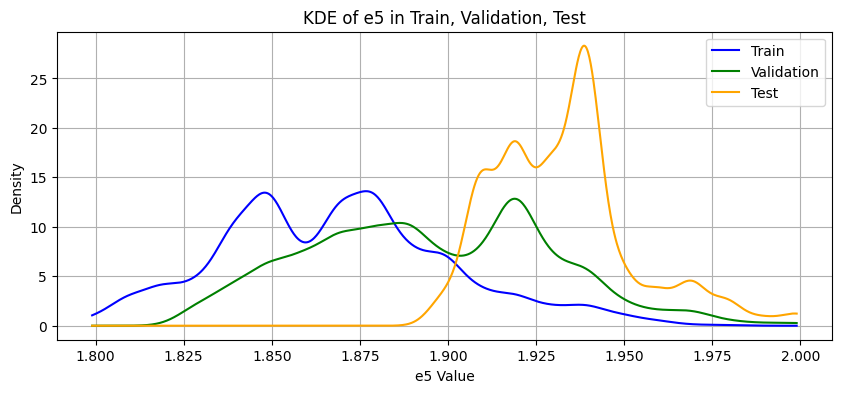

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0280 - val_loss: 0.0058
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2023-09-22 00:00:00      1.932737
2023-09-22 00:05:00      1.932780
2023-09-22 00:10:00      1.932970
2023-09-22 00:15:00      1.932194
2023-09-22 00:20:00      1.932321


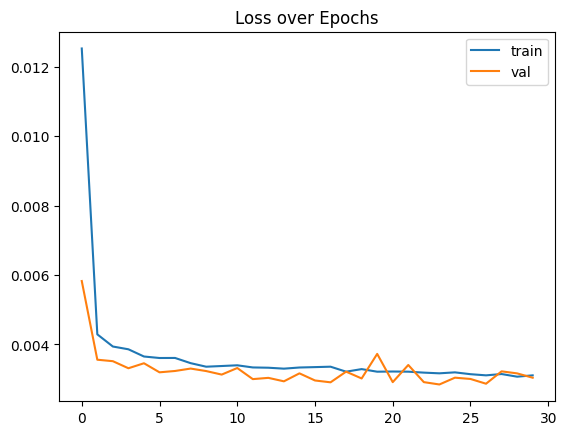

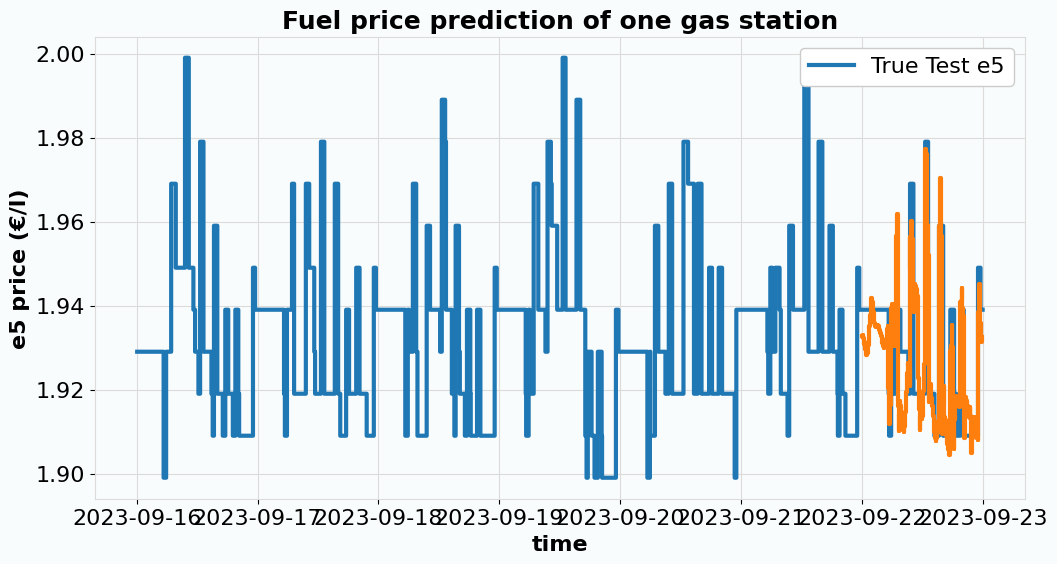

Successfully processed df21

Processing dataset: df22


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


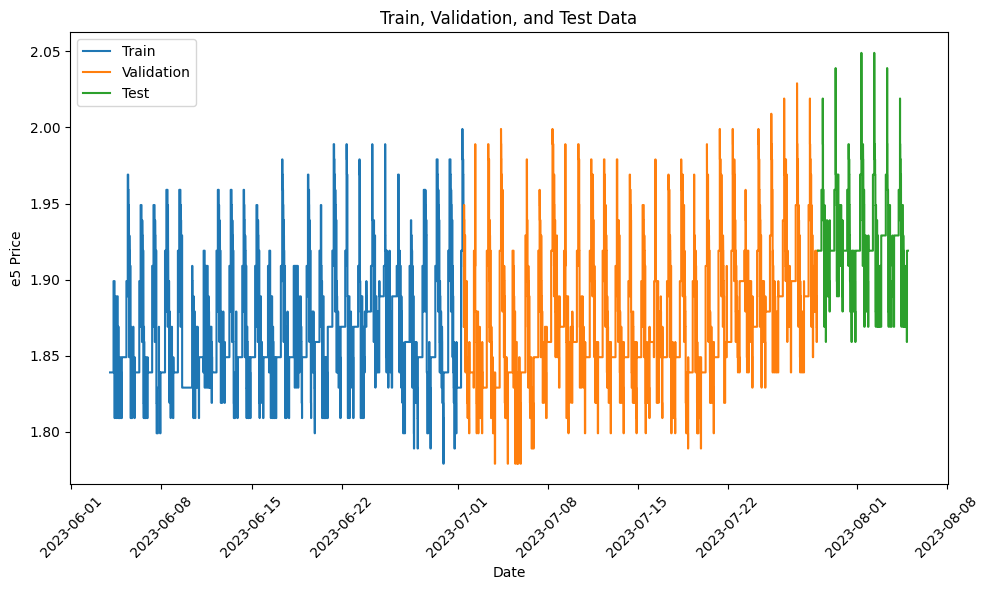

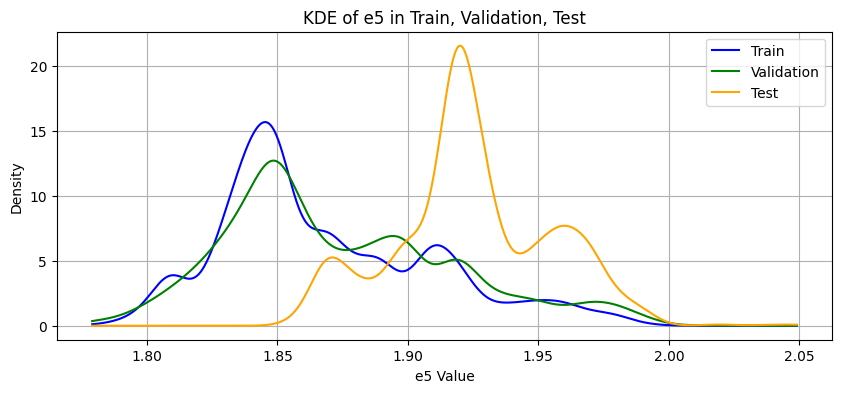

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0206 - val_loss: 0.0037
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2023-08-04 00:00:00      1.915505
2023-08-04 00:05:00      1.913499
2023-08-04 00:10:00      1.913879
2023-08-04 00:15:00      1.911442
2023-08-04 00:20:00      1.913321


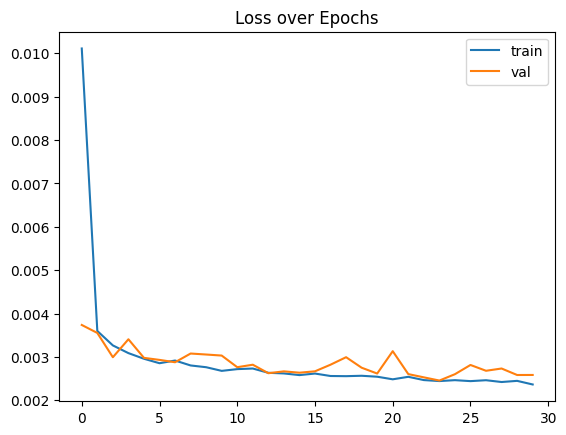

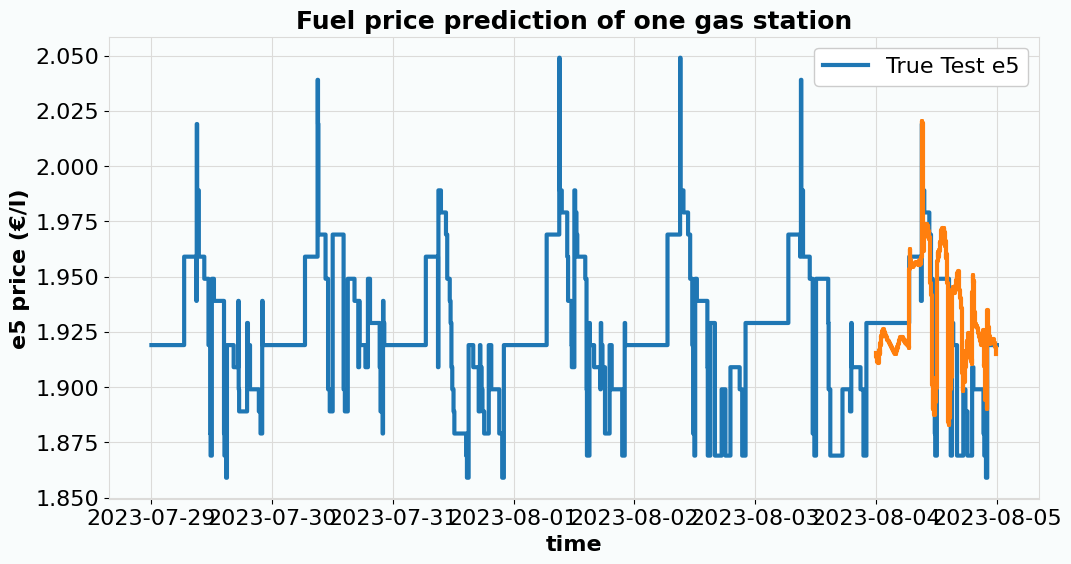

Successfully processed df22

Processing dataset: df23


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


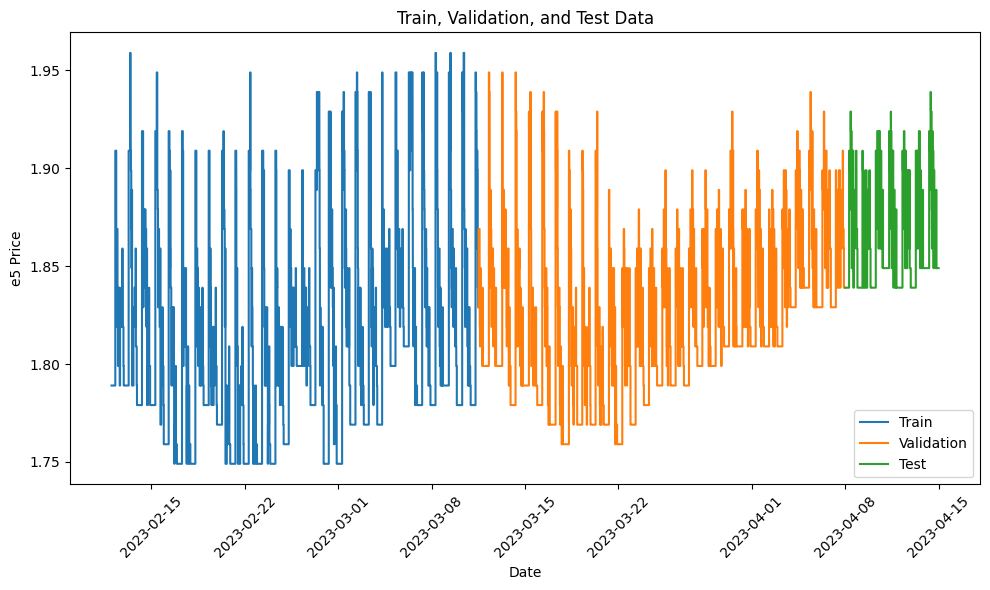

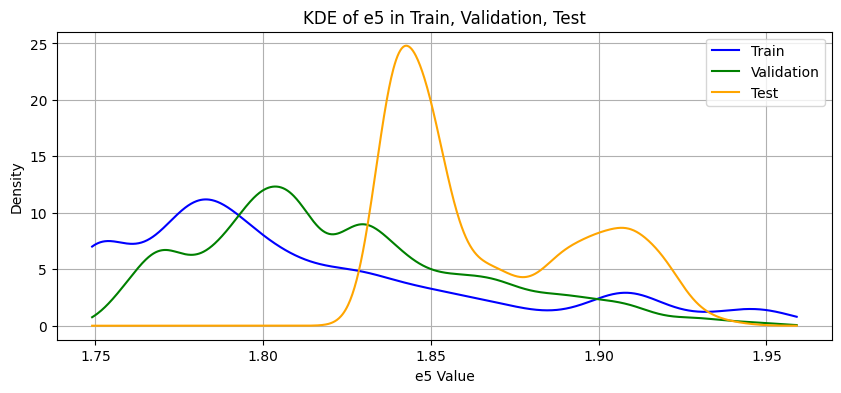

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0243 - val_loss: 0.0040
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0054 - val_loss: 0.0036
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2023-04-14 00:00:00      1.838857
2023-04-14 00:05:00      1.839000
2023-04-14 00:10:00      1.839116
2023-04-14 00:15:00      1.839252
2023-04-14 00:20:00      1.839391


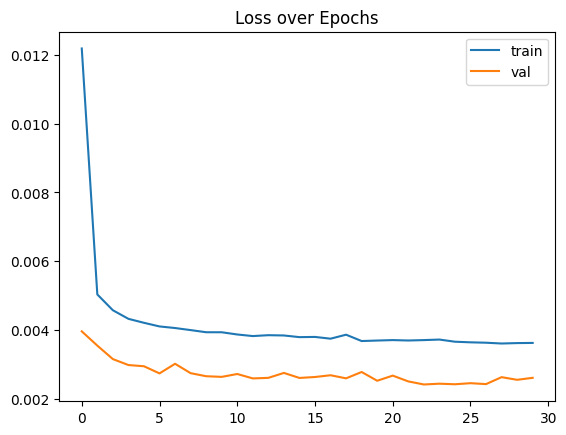

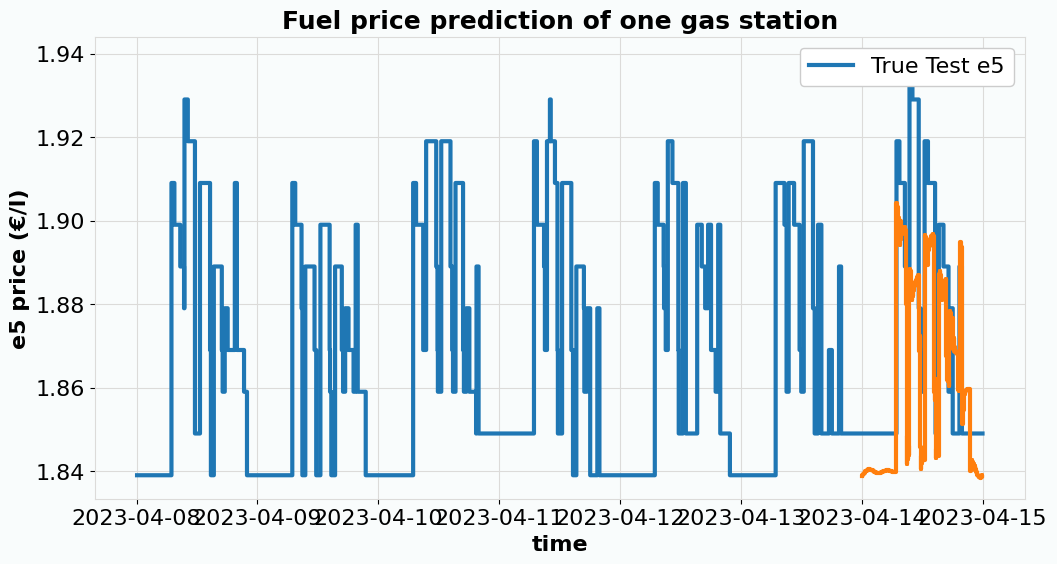

Successfully processed df23

Processing dataset: df24


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


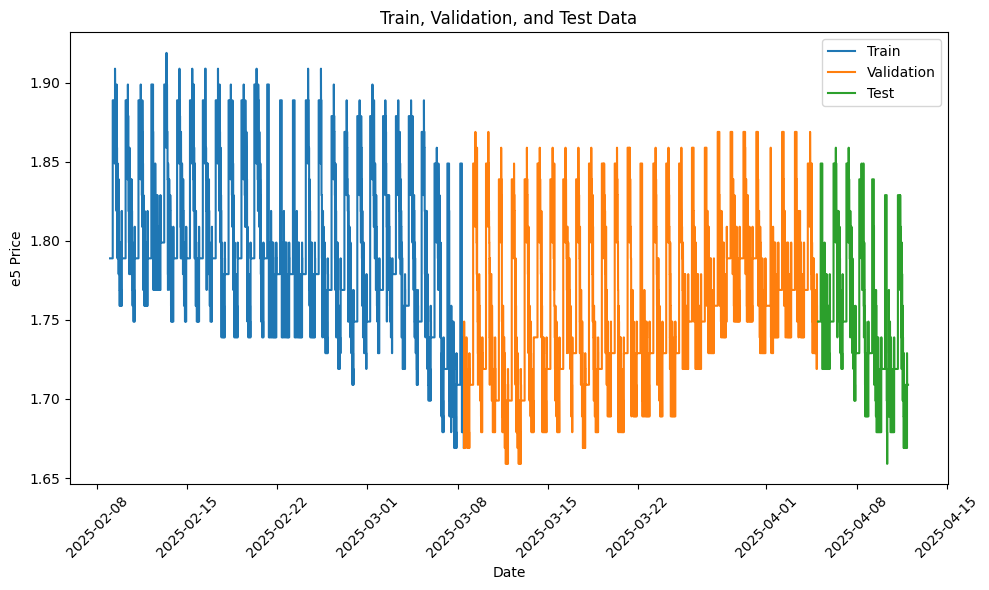

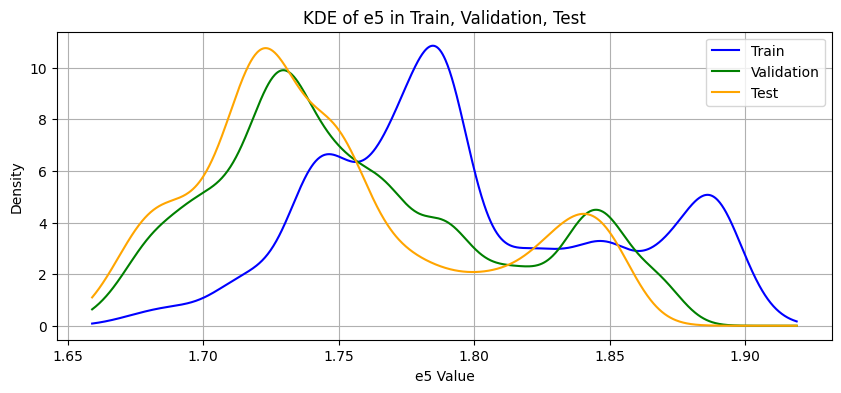

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0316 - val_loss: 0.0039
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2025-04-11 00:00:00      1.756172
2025-04-11 00:05:00      1.755349
2025-04-11 00:10:00      1.756035
2025-04-11 00:15:00      1.755196
2025-04-11 00:20:00      1.755486


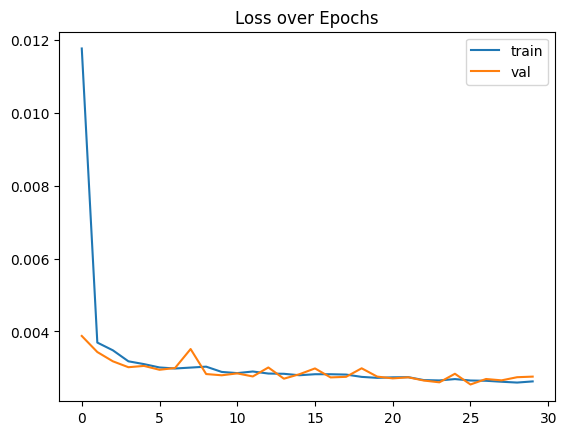

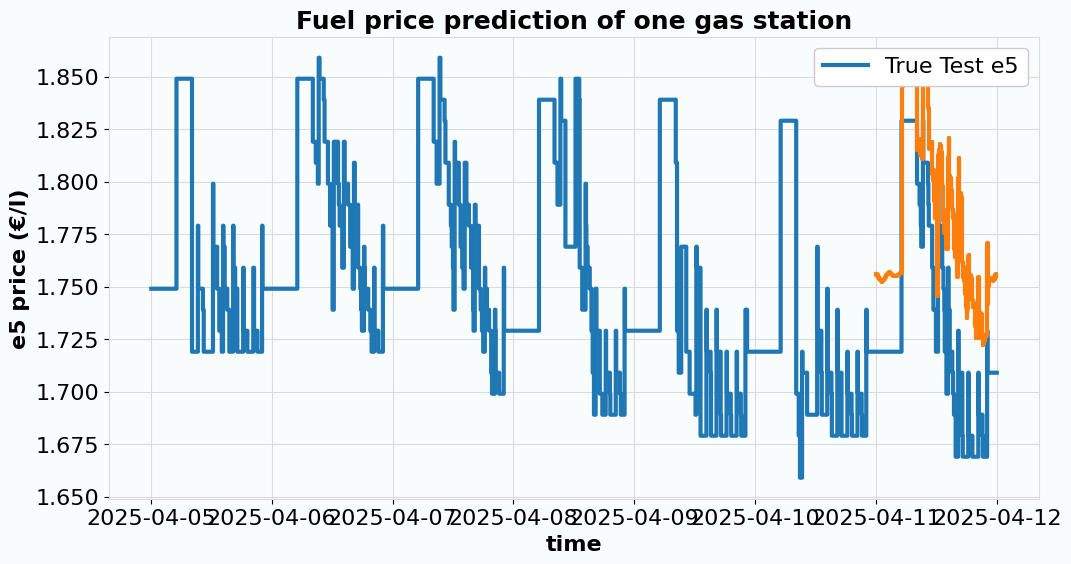

Successfully processed df24

Processing dataset: df25


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


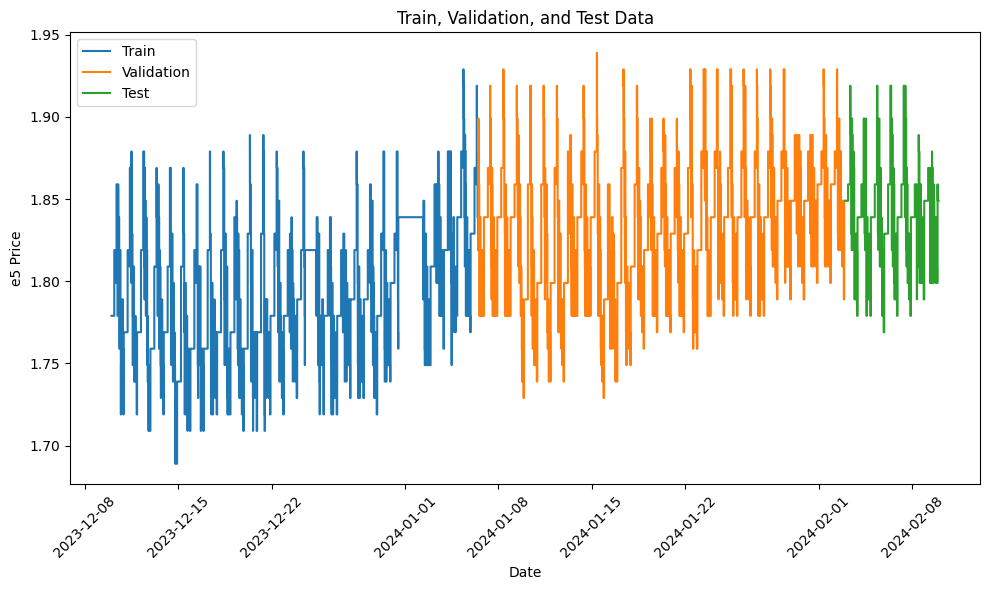

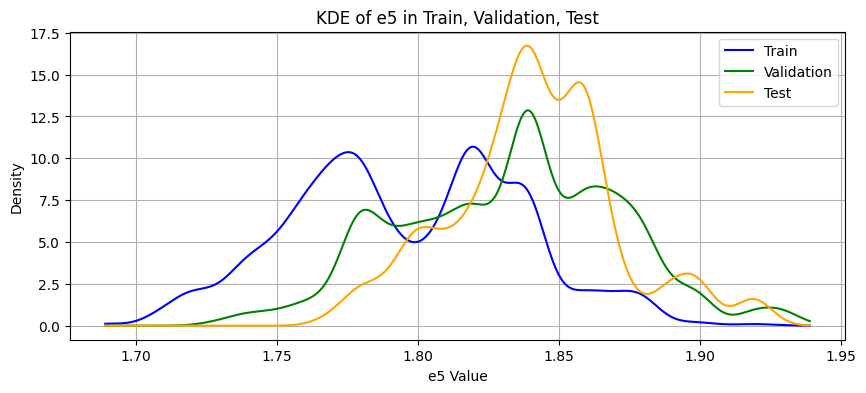

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0211 - val_loss: 0.0034
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2024-02-09 00:00:00      1.835078
2024-02-09 00:05:00      1.831912
2024-02-09 00:10:00      1.835343
2024-02-09 00:15:00      1.832441
2024-02-09 00:20:00      1.835867


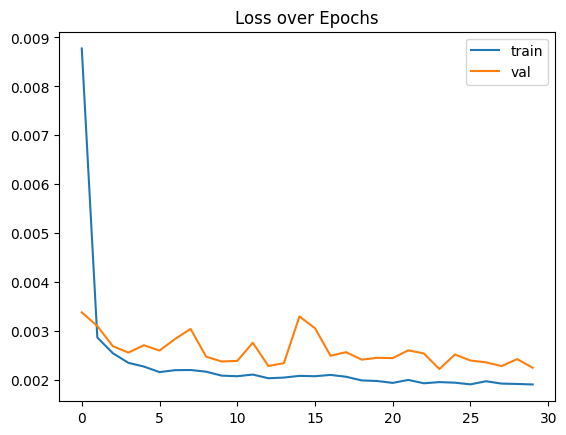

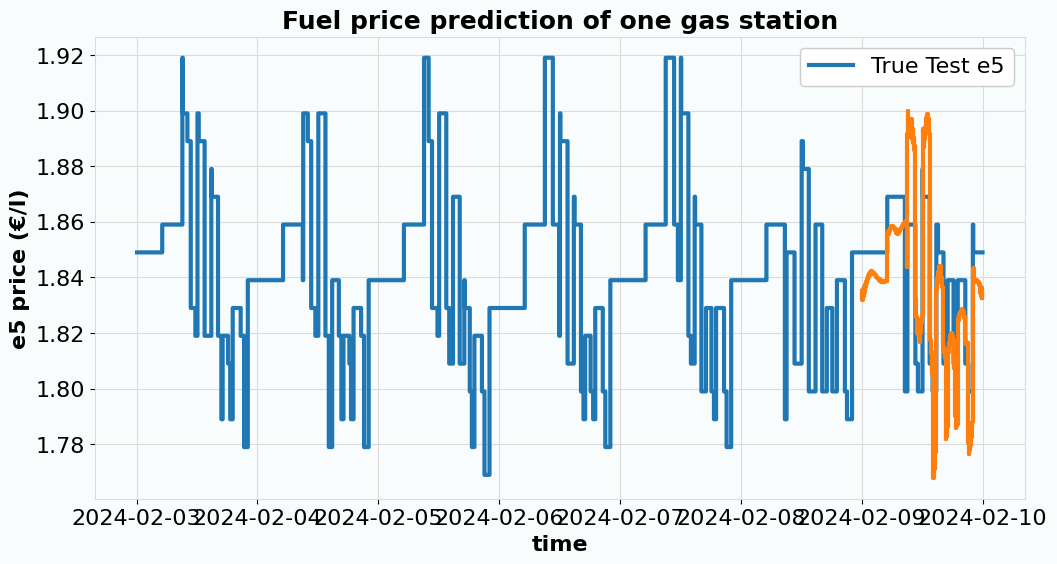

Successfully processed df25

Processing dataset: df26


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


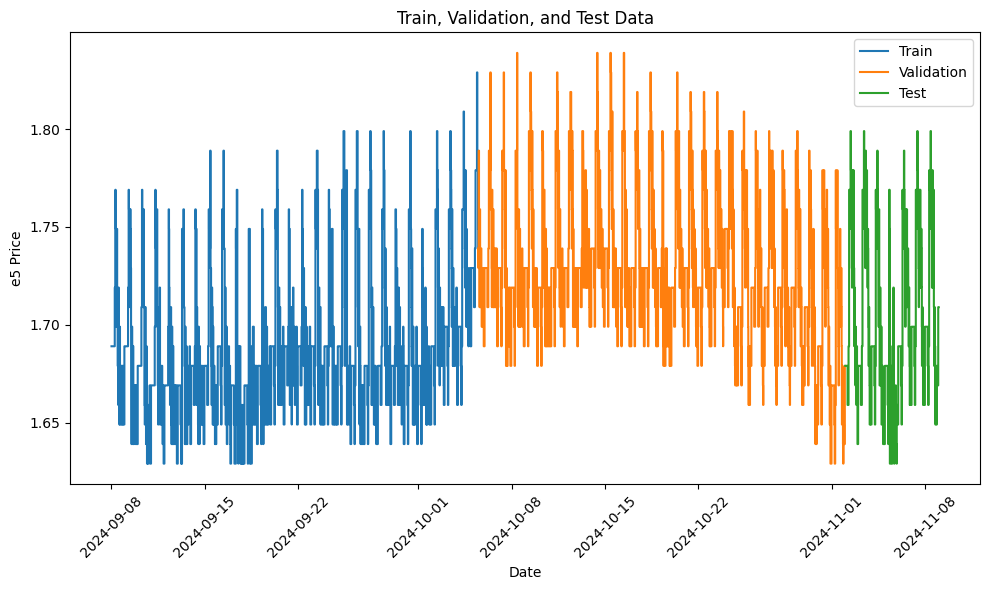

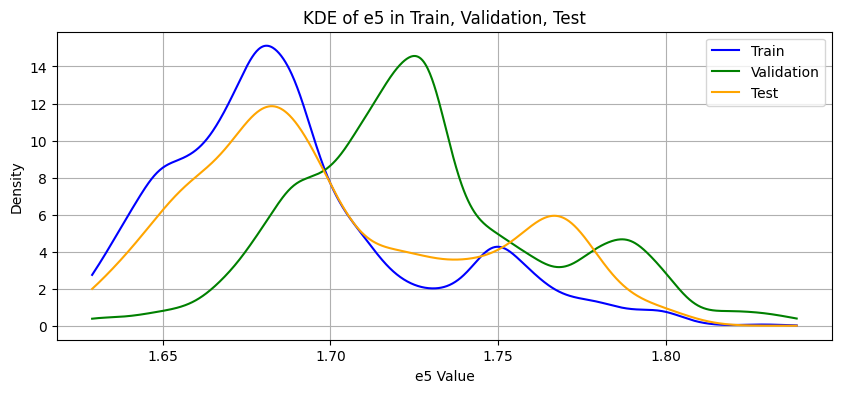

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0166 - val_loss: 0.0038
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
                     Predicted E5
datetime                         
2024-11-08 00:00:00      1.671726
2024-11-08 00:05:00      1.673120
2024-11-08 00:10:00      1.672273
2024-11-08 00:15:00      1.673628
2024-11-08 00:20:00      1.673114


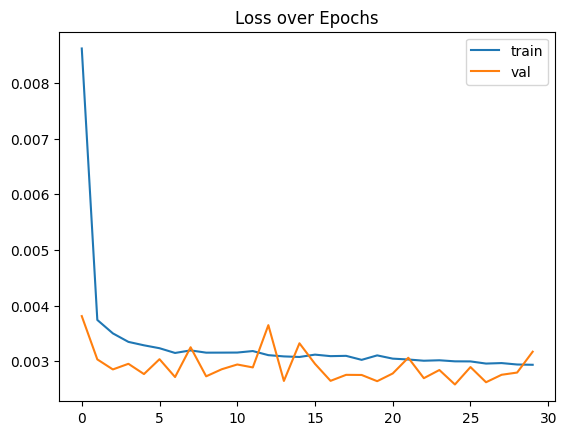

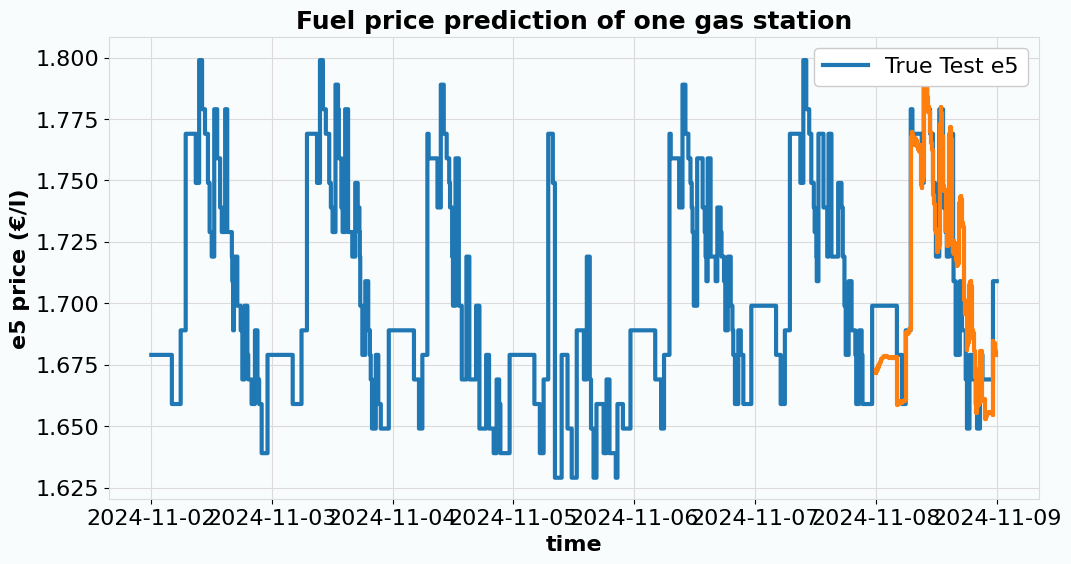

Successfully processed df26

Processing dataset: df27


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


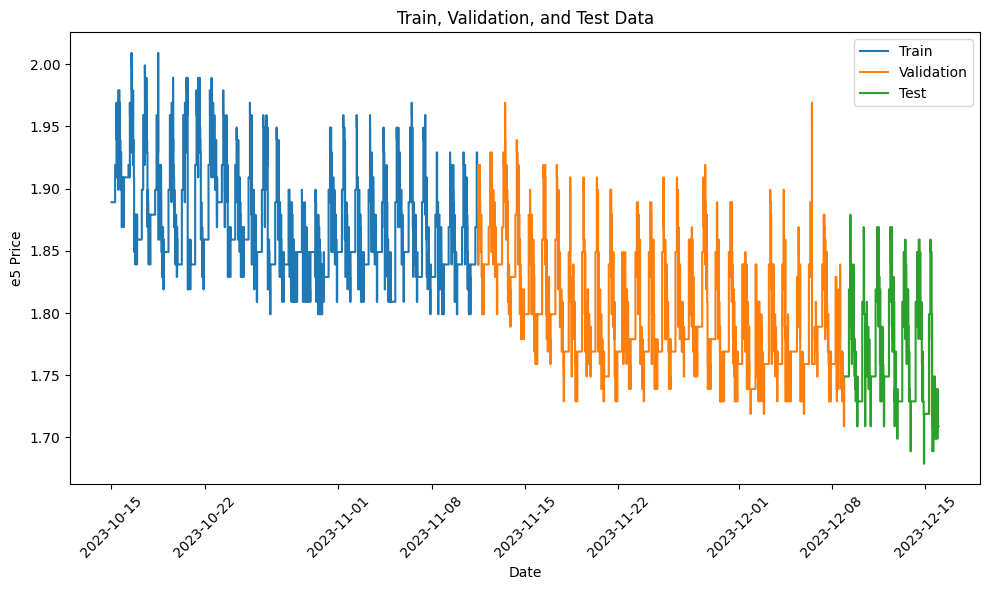

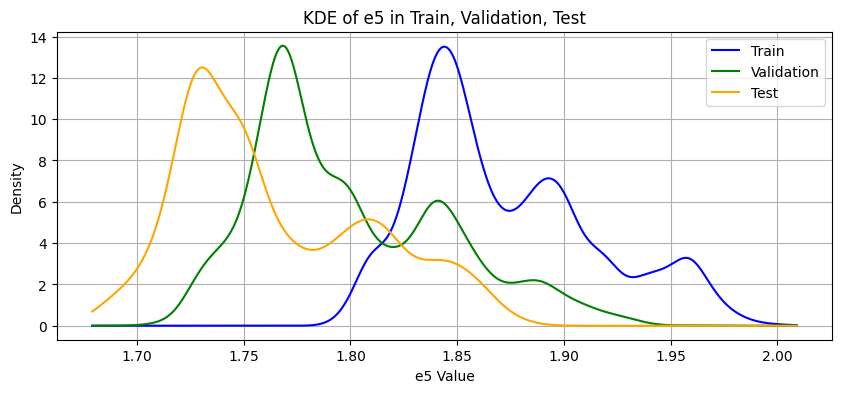

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0218 - val_loss: 0.0176
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0034 - val_loss: 0.0173
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0033 - val_loss: 0.0145
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0028 - val_loss: 0.0155
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0034 - val_loss: 0.0138
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0030 - val_loss: 0.0111
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0028 - val_loss: 0.0130
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0028 - val_loss: 0.0129
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0029 - val_loss: 0.0128
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0028 - val_loss: 0.0142
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0024 - val_loss: 0.0134
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2023-12-15 00:00:00      1.795480
2023-12-15 00:05:00      1.795336
2023-12-15 00:10:00      1.795319
2023-12-15 00:15:00      1.795166
2023-12-15 00:20:00      1.795189


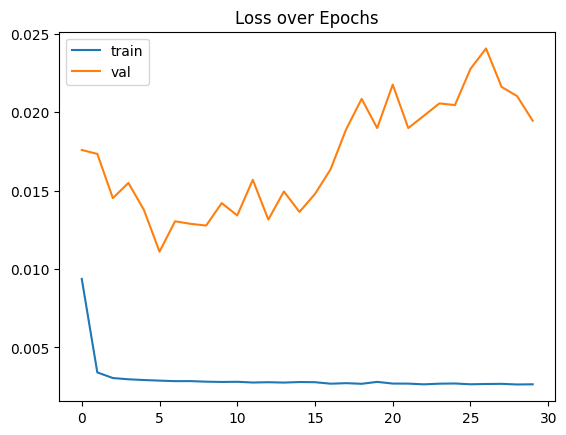

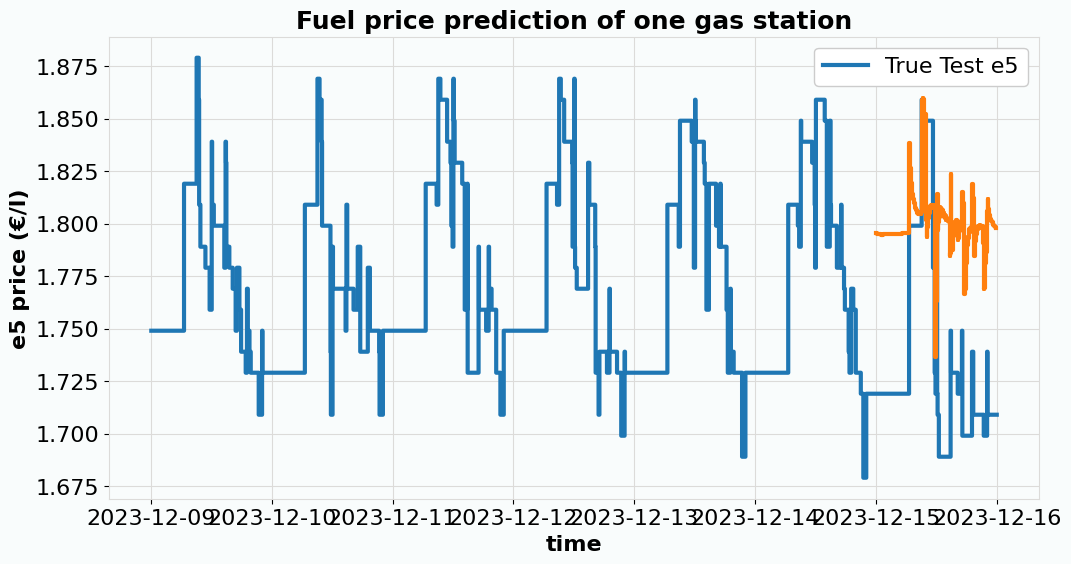

Successfully processed df27

Processing dataset: df28


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


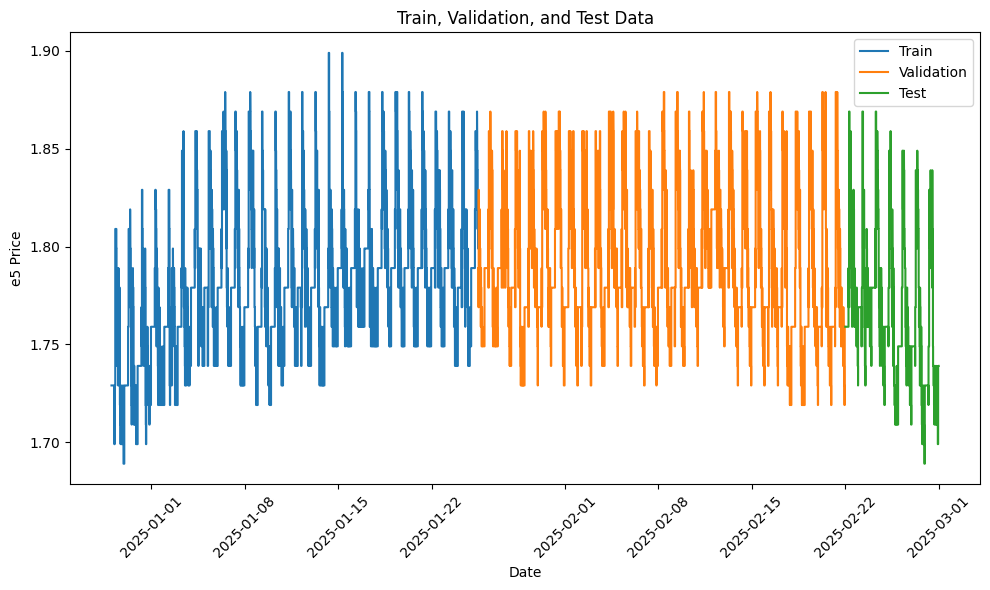

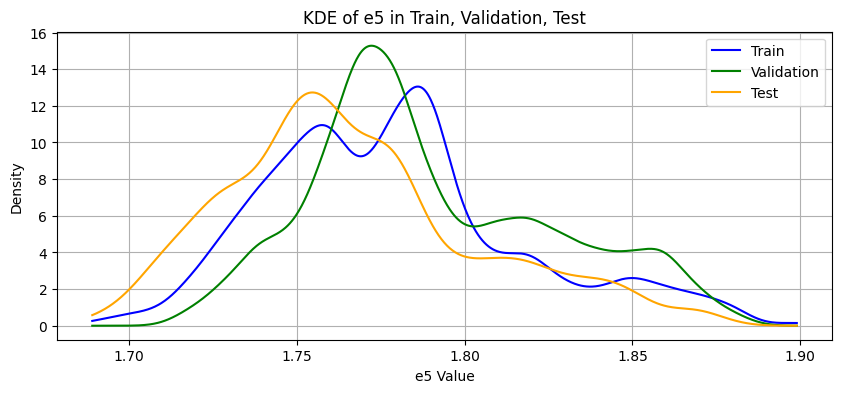

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0203 - val_loss: 0.0032
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2025-02-28 00:00:00      1.770280
2025-02-28 00:05:00      1.767562
2025-02-28 00:10:00      1.770228
2025-02-28 00:15:00      1.767768
2025-02-28 00:20:00      1.770169


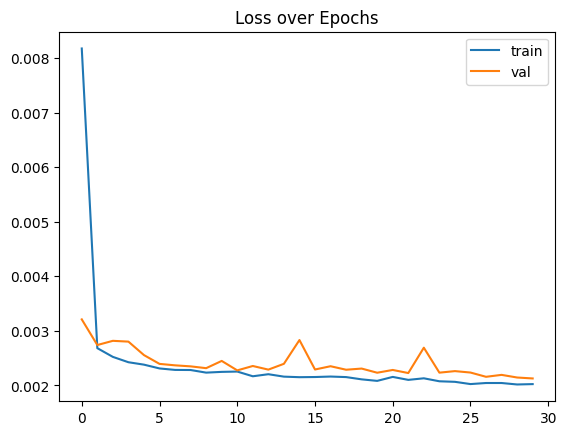

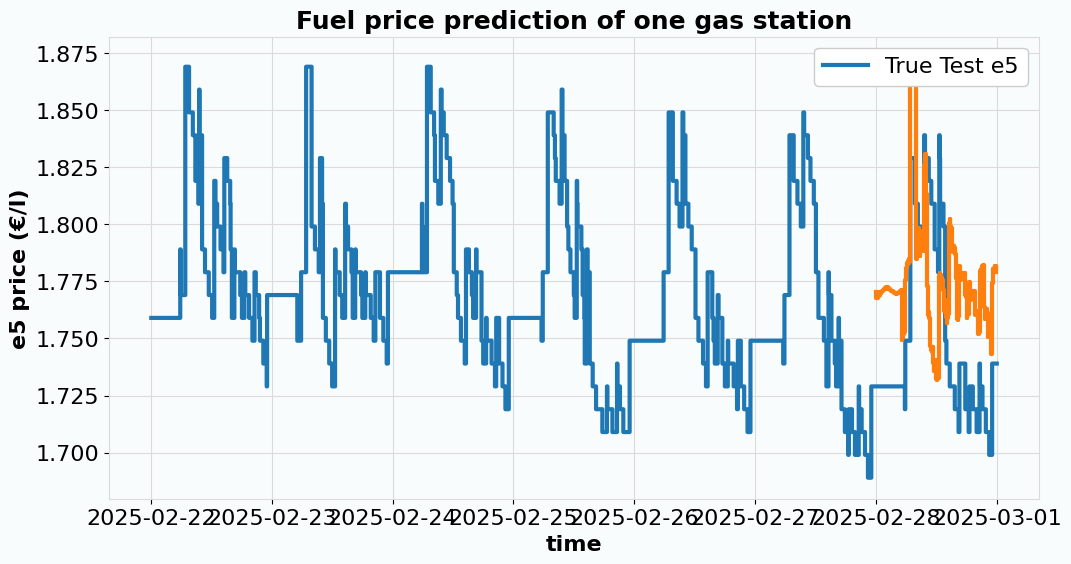

Successfully processed df28

Processing dataset: df29


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


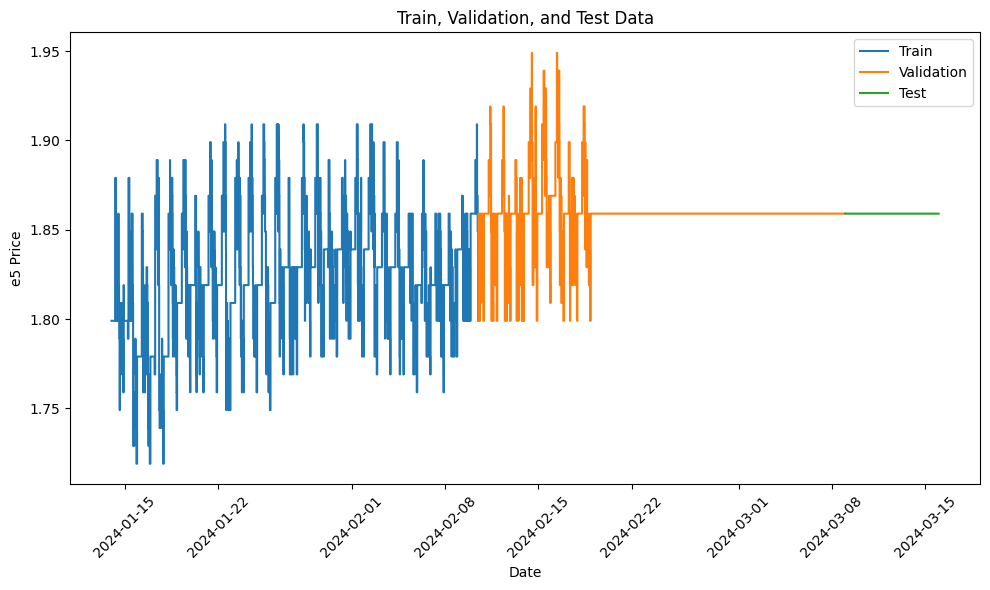

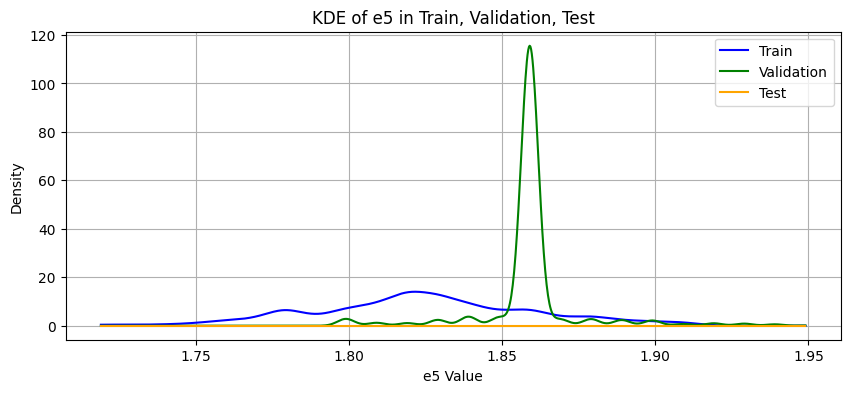

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0505 - val_loss: 0.0014
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0041 - val_loss: 9.5336e-04
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0033 - val_loss: 8.8652e-04
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0027 - val_loss: 8.8365e-04
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0028 - val_loss: 8.3865e-04
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0027 - val_loss: 9.6355e-04
Epoch 12/30
239/239 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2024-03-15 00:00:00      1.860674
2024-03-15 00:05:00      1.860674
2024-03-15 00:10:00      1.860674
2024-03-15 00:15:00      1.860674
2024-03-15 00:20:00      1.860674


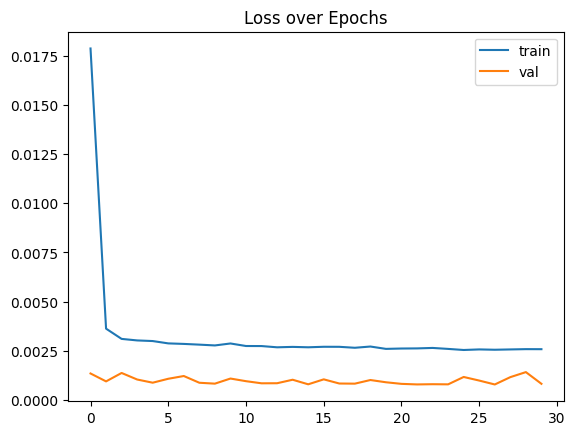

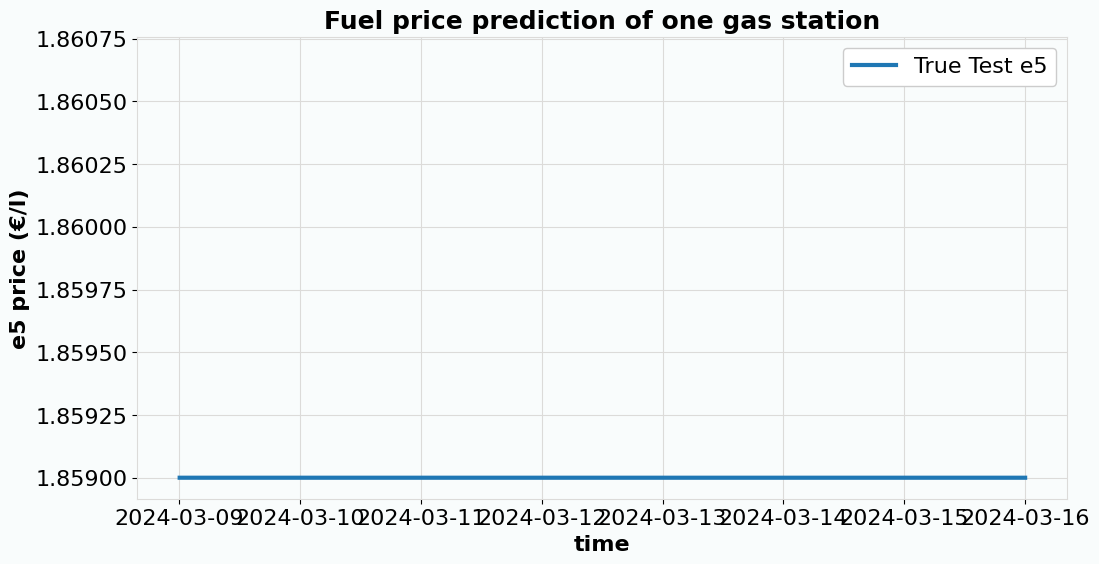

Successfully processed df29

Processing dataset: df30


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


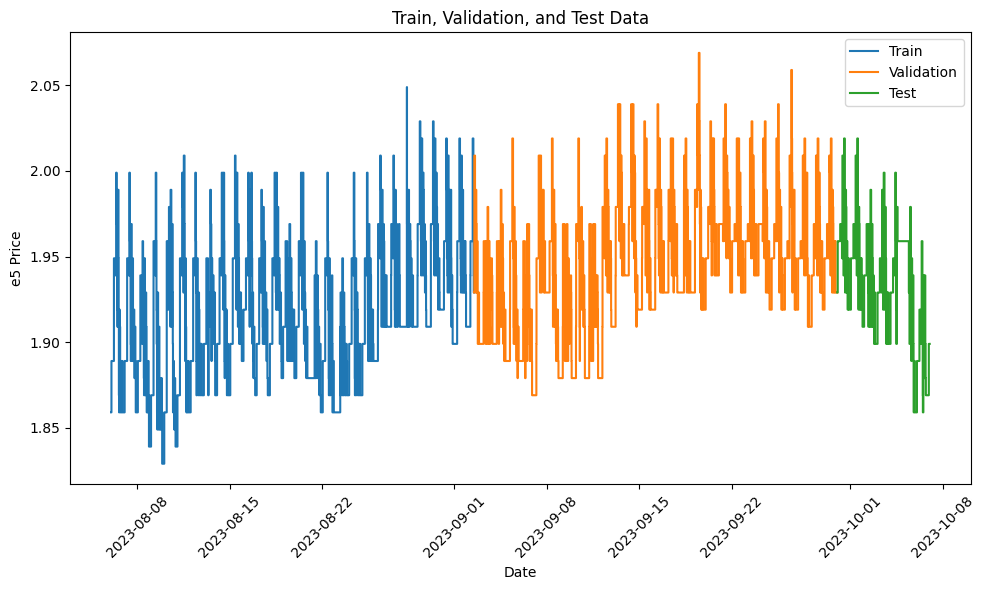

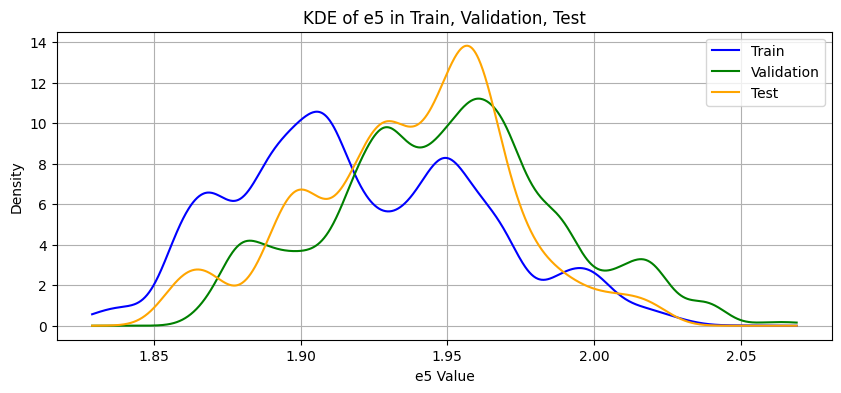

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0228 - val_loss: 0.0032
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted E5
datetime                         
2023-10-06 00:00:00      1.916213
2023-10-06 00:05:00      1.915694
2023-10-06 00:10:00      1.916138
2023-10-06 00:15:00      1.915657
2023-10-06 00:20:00      1.916087


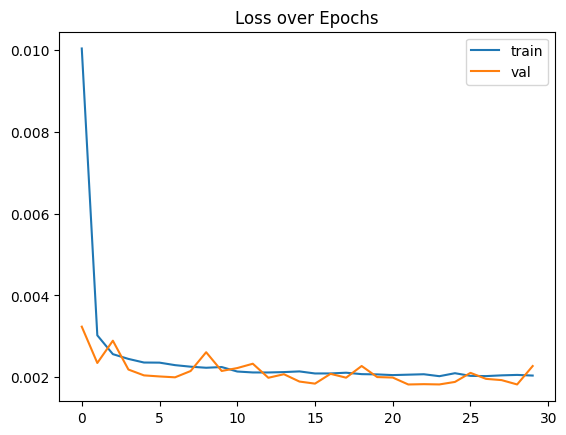

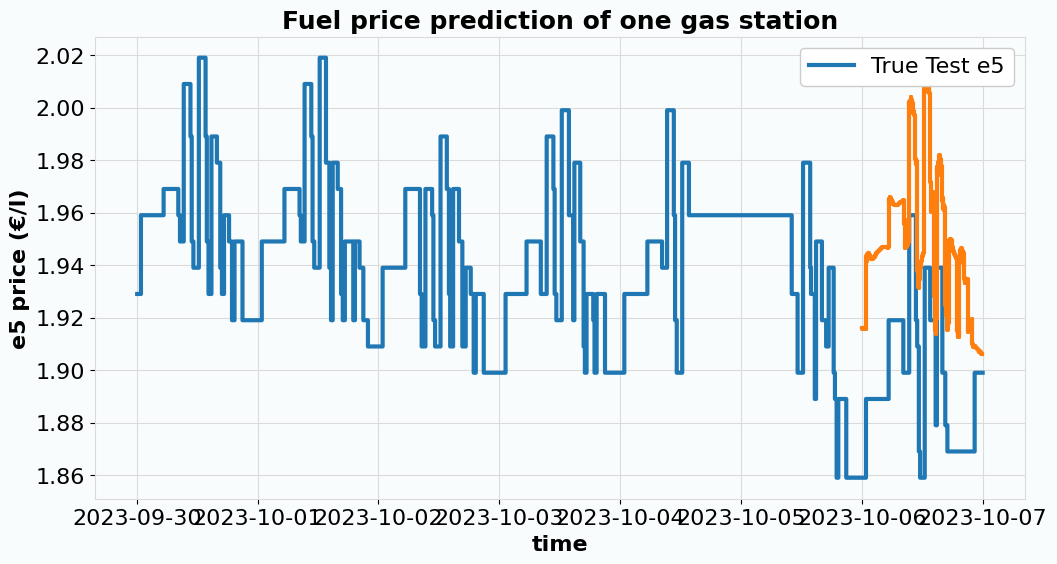

Successfully processed df30

=== Error Summary ===
Total errors: 2

df06:
Error in df06: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (288,) + inhomogeneous part.

df20:
Error in df20: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


In [9]:
# Create an error log dictionary
error_log = {}

# LOOP
for dataset_name, (df_train, df_test) in datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    
    try:
        mlflow.end_run()
        
        with mlflow.start_run(run_name=f"fuel_model_{dataset_name}") as run:
            output_days = 1 # default
            fuel='e5' # default

            # PREPROCESSING
            X, y, X_val, y_test, y_val, X_forecast, scaler, scaled_train, val_df, test_df = preprocess(
                    df_train=df_train, 
                    df_test=df_test, 
            )

            # MODELING
            params = {
                'epochs': 30,
                'batch_size': 32,
                'lstm_units': 50
            }

            model_type = 'cnn_lstm_1' # choose between: 'ccn_small', 'ccn_big' and 'cnn_lstm_1'
            
            trained_model, history = train_model_with_mlflow(
                X=X, 
                y=y, 
                X_val=X_val, 
                y_val=y_val,
                model_type=model_type,
                params=params
            )

            # FORECASTING
            forecasting(
                X_forecast=X_forecast, 
                scaled_train=scaled_train, 
                scaler=scaler, 
                model=trained_model
            )

        print(f"Successfully processed {dataset_name}")
        
    except Exception as e:
        # Log the error and continue with next dataset
        error_message = f"Error in {dataset_name}: {str(e)}"
        error_log[dataset_name] = error_message
        print(error_message)
        
        # Make sure to end the MLflow run if it failed
        mlflow.end_run()
        continue

# After the loop, print summary of errors
print("\n=== Error Summary ===")
if error_log:
    print(f"Total errors: {len(error_log)}")
    for dataset, error in error_log.items():
        print(f"\n{dataset}:")
        print(error)
else:
    print("All datasets processed successfully!")

=== Error Summary ===
Total errors: 2

df06:
Error in df06: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (288,) + inhomogeneous part.

df20:
Error in df20: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

In [8]:
mlflow.end_run()

# Checking your data with MLFlow:
Start the MLFlow by entering "mlflow ui" into the Terminal and opening the given uri in your browser.
To abort MLflow again, go to terminal and press "ctrl+c".

In [ ]:
%mlflow ui --backend-store-uri file:data/mlflow